<a href="https://colab.research.google.com/github/LimSeunghyeon1/Pitcher_pose_estimation/blob/master/Pitcher_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torchvision
import torch.nn

In [ ]:
!pip3 install --upgrade torch torchvision

In [ ]:
torch.cuda.is_available()


True

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given youtube video.

For other deep-learning Colab notebooks, visit [tugstugi/dl-colab-notebooks](https://github.com/tugstugi/dl-colab-notebooks).


## Install OpenPose

In [ ]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Selecting previously unselected package libgflags2.2.
(Reading database ... 155219 files and directories currently installed.)
Preparing to unpack .../00-libgflags2.2_2.2.1-1_amd64.deb ...
Unpacking libgflags2.2 (2.2.1-1) ...
Selecting previously unselected package libgflags-dev.
Preparing to unpack .../01-libgflags-dev_2.2.1-1_amd64.deb ...
Unpacking libgflags-dev (2.2.1-1) ...
Selecting previously unselected package libgoogle-glog0v5.
Preparing to unpack .../02-libgoogle-glog0v5_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog0v5 (0.3.5-1) ...
Selecting previously unselected package libgoogle-glog-dev.
Preparing to unpack .../03-libgoogle-glog-dev_0.3.5-1_amd64.deb ...
Unpacking libgoogle-glog-dev (0.3.5-1) ...
Selecting previously unselected package libhdf5-serial-dev.
Preparing to unpack .../04-libhdf5-serial-dev_1.10.0-patch1+docs-4_all.deb ...
Unpacking libhdf5-serial-dev (1.10.0-patch1+docs-4) ...
Selecting previously unselected package libleveldb1v5:amd64.
Preparing to unpack ...

# 모든영상에서 frame뽑기



n 번째 뽑은 후 frame n.jpg로 저장

object detection으로 pitcher만 bounding box 처리

그리고 그 bounding box 내의 이미지만 pitcher n.jpg로 저장

In [ ]:
'''
#frame_image 폴더가 없으면 폴더를 만든다
!mkdir frame_image
'''

In [ ]:
'''
# frame 1~n.jpg 저장
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_frame(video,begin_cnt):
  cap= cv2.VideoCapture(video)
  while(cap.isOpened()):
      ret, frame = cap.read()
      if ret == False:
          break

      # 디렉토리는 frame_image
      cv2.imwrite(f"frame_image/frame{begin_cnt}.jpg",frame)
      begin_cnt+=1  
  cap.release()
  cv2.destroyAllWindows()
  return begin_cnt
  '''

In [ ]:
#pitcher를 detection을 하기전 pretraining data를 다운받음 (shell 코드 기반)

'''
def pitcher_pretraining():
  !mkdir ./pretrained
  !wget -O ./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
  !wget -O ./pretrained/config_graph.pbtxt https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
  !tar -xvf ./pretrained/faster*.tar.gz -C ./pretrained 
  !pwd
  !ls -lia ./pretrained/faster_rcnn_resnet50_coco_2018_01_28
  cv_net = cv2.dnn.readNetFromTensorflow('./pretrained/faster_rcnn_resnet50_coco_2018_01_28/frozen_inference_graph.pb', 

                                     './pretrained/config_graph.pbtxt')
  return cv_net
  '''
  

In [ ]:
'''
def pitcher_detection(img,cv_net):
  rows = img.shape[0]
  cols = img.shape[1]

  draw_img = img.copy()

  # 원본 이미지 배열 BGR을 RGB로 변환하여 배열 입력. Tensorflow Faster RCNN은 마지막 classification layer가 Dense가 아니여서 size를 고정할 필요는 없음.  
  cv_net.setInput(cv2.dnn.blobFromImage(img, swapRB=True, crop=False))

  cv_out = cv_net.forward()
  # 차원축소
  reduction = np.squeeze(cv_out)
  detection_output_list = reduction.tolist()
  # bounding box의 테두리와 caption 글자색 지정
  green_color=(0, 255, 0)
  red_color=(0, 0, 255)


  # detection한 사람중 bounding box bottom이 가장 큰 사람의 idx
  max = 0
  bottoms = []

  # detected 된 object들을 iteration 하면서 정보 추출
  for order, detection in enumerate(detection_output_list):
      score = float(detection[2])
      class_id = int(detection[1])
      # detected된 object들의 score가 0.9 이상과 사람인 경우만 추출
      if score > 0.9 and class_id == 0:
          print("this is " +str(order)+ "th picture")
          # detected된 object들은 scale된 기준으로 예측되었으므로 다시 원본 이미지 비율로 계산
          left = detection[3] * cols
          top = detection[4] * rows
          right = detection[5] * cols
          bottom = detection[6] * rows

          # 가장  bottom 값이 큰 것을 저장

          # 리스트가 비었으면:
          if not bottoms:
            bottoms.append([left,top,right,bottom])
          # 리스트가 안 비었으면
          else:
            if bottom>bottoms[max][3]:
              bottoms.pop()
              bottoms.append([left,top,right,bottom])

          # labels_to_names_seq 딕셔너리로 class_id값을 클래스명으로 변경.
          caption = "{}: {:.4f}".format("person", score)
          print(caption)
          #cv2.rectangle()은 인자로 들어온 draw_img에 사각형을 그림. 위치 인자는 반드시 정수형.
          cv2.rectangle(draw_img, (int(left), int(top)), (int(right), int(bottom)), color=green_color, thickness=2)
          cv2.putText(draw_img, caption, (int(left), int(top - 5)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, red_color, 1)
  img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
  # 투수 bbox 작업
  print(bottoms)

  pitcher_bbx = []
  for x in bottoms[0]:
    pitcher_bbx.append(int(x))
  print("original bbx is ",pitcher_bbx[0])
  if pitcher_bbx[0]-50>0:
    pitcher_bbx[0]=pitcher_bbx[0]-100
  else:
    pitcher_bbx[0]=0
  if pitcher_bbx[2]+50<img.shape[1]:
    pitcher_bbx[2]=pitcher_bbx[2]+50
  else:
    pitcher_bbx[2]=img.shape[1]
  print("after bbx is ",pitcher_bbx)
  return pitcher_bbx  #[x_low y_low x_high y_high]
  '''

In [ ]:
'''
#pitcher_bbx를 토대로 opencv로 pitcher_frame n.jpg 만들기
! mkdir pitcher_image
def get_pitcher_img(img, pitcher_bbx,cnt):
  x_low=pitcher_bbx[0]
  y_low=pitcher_bbx[1]
  x_high=pitcher_bbx[2]
  y_high=pitcher_bbx[3]
  #cv2_imshow(img)
  new_img=img[y_low:y_high,x_low:x_high].copy()
  
  cv2.imwrite(f'pitcher_image/pitcher_frame{cnt}.jpg',new_img)
  '''
  

In [ ]:
#cv_net=pitcher_pretraining()

--2021-11-16 02:19:36--  http://download.tensorflow.org/models/object_detection/faster_rcnn_resnet50_coco_2018_01_28.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.153.128, 2a00:1450:4013:c16::80
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.153.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 381355771 (364M) [application/x-tar]
Saving to: ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’

./pretrained/faster 100%[===================>] 363.69M  73.8MB/s    in 5.2s    

2021-11-16 02:19:42 (70.3 MB/s) - ‘./pretrained/faster_rcnn_resnet50_coco_2018_01_28.tar.gz’ saved [381355771/381355771]

--2021-11-16 02:19:42--  https://raw.githubusercontent.com/opencv/opencv_extra/master/testdata/dnn/faster_rcnn_resnet50_coco_2018_01_28.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.

In [ ]:
'''
!mkdir pitcher_video
def save_video(begin_cnt,end_cnt,cnt):#cnt는 비디오
  frame_array=[]
  pathOut=f'pitcher_video/changeup_input{cnt}.mp4'
  fps=30
  for i in range(begin_cnt,end_cnt):
    img=cv2.imread(f'pitcher_image/pitcher_frame{i}.jpg')
    height,width,layers=img.shape
    size=(width,height)
    frame_array.append(img)
  out=cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'),fps,size)
  for i in range(len(frame_array)):
    out.write(frame_array[i])
  out.release()
   ''' 


mkdir: cannot create directory ‘pitcher_video’: File exists


## **Main function**

video를 input을 하고
pitcher_frame n.jpg 형태로 frame을 다 crop한다

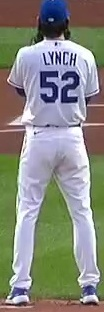

예시 pitcher_frame1.jpg


In [ ]:
 '''
 from google.colab.patches import cv2_imshow
begin_cnt=0


for i in range (1,101):
  print(i)
  end_cnt=get_frame(f'drive/MyDrive/urp/Daniel Lynch/changeup/changeup{i}.mp4',begin_cnt)
  #for j in range(begin_cnt,end_cnt):
  img=cv2.imread(f"frame_image/frame{begin_cnt}.jpg",cv2.IMREAD_COLOR) 
  if img is None:
    print("img is none")
  pitcher_bbx=pitcher_detection(img,cv_net)
  for j in range(begin_cnt,end_cnt):
    pic=cv2.imread(f"frame_image/frame{j}.jpg",cv2.IMREAD_COLOR)
    get_pitcher_img(pic,pitcher_bbx,j) #j번째 pitcher image 형상화 완료 directory는 pitcher_image/pitcher_frame{cnt}.jpg
  save_video(begin_cnt,end_cnt,i)
    

  end_cnt=begin_cnt

print("done!!")
'''

In [ ]:
'''
!mkdir drive/MyDrive/urp/Daniel\ Lynch/input_video/changeup
for i in range (1,101):
  !mv pitcher_video/changeup_input{i}.mp4 drive/MyDrive/urp/Daniel\ Lynch/input_video/changeup/changeup_input{i}.mp4
'''

mkdir: cannot create directory ‘drive/MyDrive/urp/Daniel Lynch/input_video/sinker’: File exists


## 이제 openpose로 output file을 만들고 거기에 있는 feature들을 뽑아낸다.

In [ ]:

temp=0
max_idx=0
#find frame number 
def get_glovepos(ankle_list):
  for i in range (0,len(ankle_list)):
    if max(ankle_list[i],temp)==ankle_list[i]:
      temp=ankle_list[i]
      max_idx=i
    print(max_idx)
    return (df['people'][0][0]['pose_keypoints_2d'][21],df['people'][0][0]['pose_keypoints_2d'][22])


In [ ]:
#나중에 json file을 read할때 사용

import pandas as pd
cnt=0
#print(f"{format(cnt,'')}")
def r_file(file_dir):
  df=pd.read_json(file_dir,lines=True)
  if df is None:
    print("json file not found")
  else:
    #print(df['people'][0][2]['pose_keypoints_2d'])
    if len(df['people'][0])==1:
      cand=df['people'][0][0]['pose_keypoints_2d'][43]
      if cand !=0:
        print('people detection',df['people'][0][0]['pose_keypoints_2d'][43])
        return df['people'][0][0]['pose_keypoints_2d'][43] #x y c(confidece)

      
    elif len(df['people'][0])>1:   
      temp=99999
      idx=0
      #print(df['people'][0][0])
      for i in range(0,len(df['people'][0])):
        cand=df['people'][0][i]['pose_keypoints_2d'][42]
        #print(cand)
        if min(temp,cand)==cand and cand!=0:
          temp=cand
          idx=i
        print('many people detection',df['people'][0][idx]['pose_keypoints_2d'][43])
        return df['people'][0][idx]['pose_keypoints_2d'][43]
    else:
      print("no humans found")
      return 0
    
token=0
'''
while 1:
  print(cnt)
  file_dir=f"openpose/output/video_{format(cnt,'012')}_keypoints.json"
  try :
    df=pd.read_json(file_dir,lines=True)
     
  except ValueError:
    print("All done.")
    break 
  else:
    df=pd.read_json(file_dir,lines=True)
    r_file(file_dir)
  cnt+=1
print(len(ankle_list))
'''

'\nwhile 1:\n  print(cnt)\n  file_dir=f"openpose/output/video_{format(cnt,\'012\')}_keypoints.json"\n  try :\n    df=pd.read_json(file_dir,lines=True)\n     \n  except ValueError:\n    print("All done.")\n    break \n  else:\n    df=pd.read_json(file_dir,lines=True)\n    r_file(file_dir)\n  cnt+=1\nprint(len(ankle_list))\n'

In [ ]:
#shell script 불러오는 코드  json파일을 생성하고 drive로 파일을 옮긴다.
!mkdir /content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json
!mkdir /content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/sinker
!mkdir /content/output
!mkdir /content/output/sinker
!mkdir drive/MyDrive/urp/Daniel_Lynch/glove_pos
pitch_type="slider"
f=open(f"drive/MyDrive/urp/Daniel_Lynch/glove_pos/glove_{pitch_type}.txt","w")
import pandas as pd
cnt=0
ankle_list=list()


for c in range (1,105):
  pass
  #print("c is",c)

  input_file=f"/content/drive/MyDrive/urp/Daniel_Lynch/input_video/{pitch_type}/{pitch_type}_input{c}.mp4"
  ouput_file=f"/content/output/{pitch_type}_output{c}.mp4"
  ! rm -rf /content/video.mp4
#  ! ffmpeg -i $input_file -filter:v "crop=380:540:320:180" /content/video.mp4
#  ! -filter:v "crop=380:540:320:180" /content/video.mp4
  ! rm -rf /content/openpose.avi
  ##여기부분 수정 input_file
  ! cd /content/openpose && ./build/examples/openpose/openpose.bin --video $input_file --write_json ./output/ --display 0  --write_video ../openpose.avi
  ! ffmpeg -y -loglevel info -i /content/openpose.avi $output_file 
  #show_local_mp4_video(f'output{c}.mp4',width=960,height=720)
  
  cnt=0


for c in range (0,105):
  cnt=0
  while 1:
    print(cnt)
    file_dir=f"/content/openpose/output/{pitch_type}_input{c}_{format(cnt,'012')}_keypoints.json"
    !mkdir /content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/{pitch_type}/{c}
    dst_dir=f"/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/{pitch_type}/{c}/{pitch_type}_input{c}_{format(cnt,'012')}_keypoints.json"
    cnt+=1
    try :
      df=pd.read_json(file_dir,lines=True)
     
    except ValueError:
     print("All done.")
     break 
    else:
      !mv $file_dir $dst_dir    
      #df=pd.read_json(file_dir,lines=True)
      #ankle_list.append(r_file(file_dir))
  #posx,posy=get_glovepos(ankle_list)
  

  
  
  



스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
81
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
82
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
83
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
84
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
85
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
86
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
87
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
88
mkdir: cannot create directory ‘/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/slider/24’: File exists
89
mkdir: cannot create directory ‘/content/drive/My

In [ ]:
#이제 glove feature를 뽑아내자
pitch_type="sliderr"

for c in range(1,105):
  cnt=0
  while 1:
      print(cnt)
      json_dir=f"/content/drive/MyDrive/urp/Daniel_Lynch/keypoints_json/{pitch_type}/{c}/{pitch_type}_input{c}_{format(cnt,'012')}_keypoints.json"
      cnt+=1
      try :
        df=pd.read_json(json_dir,lines=True)
      
      except ValueError:
        print("All done.")
        break 
      else:    
        df=pd.read_json(file_dir,lines=True)
        ankle_list.append(r_file(file_dir))
  posx,posy=get_glovepos(ankle_list)

0
All done.


TypeError: ignored

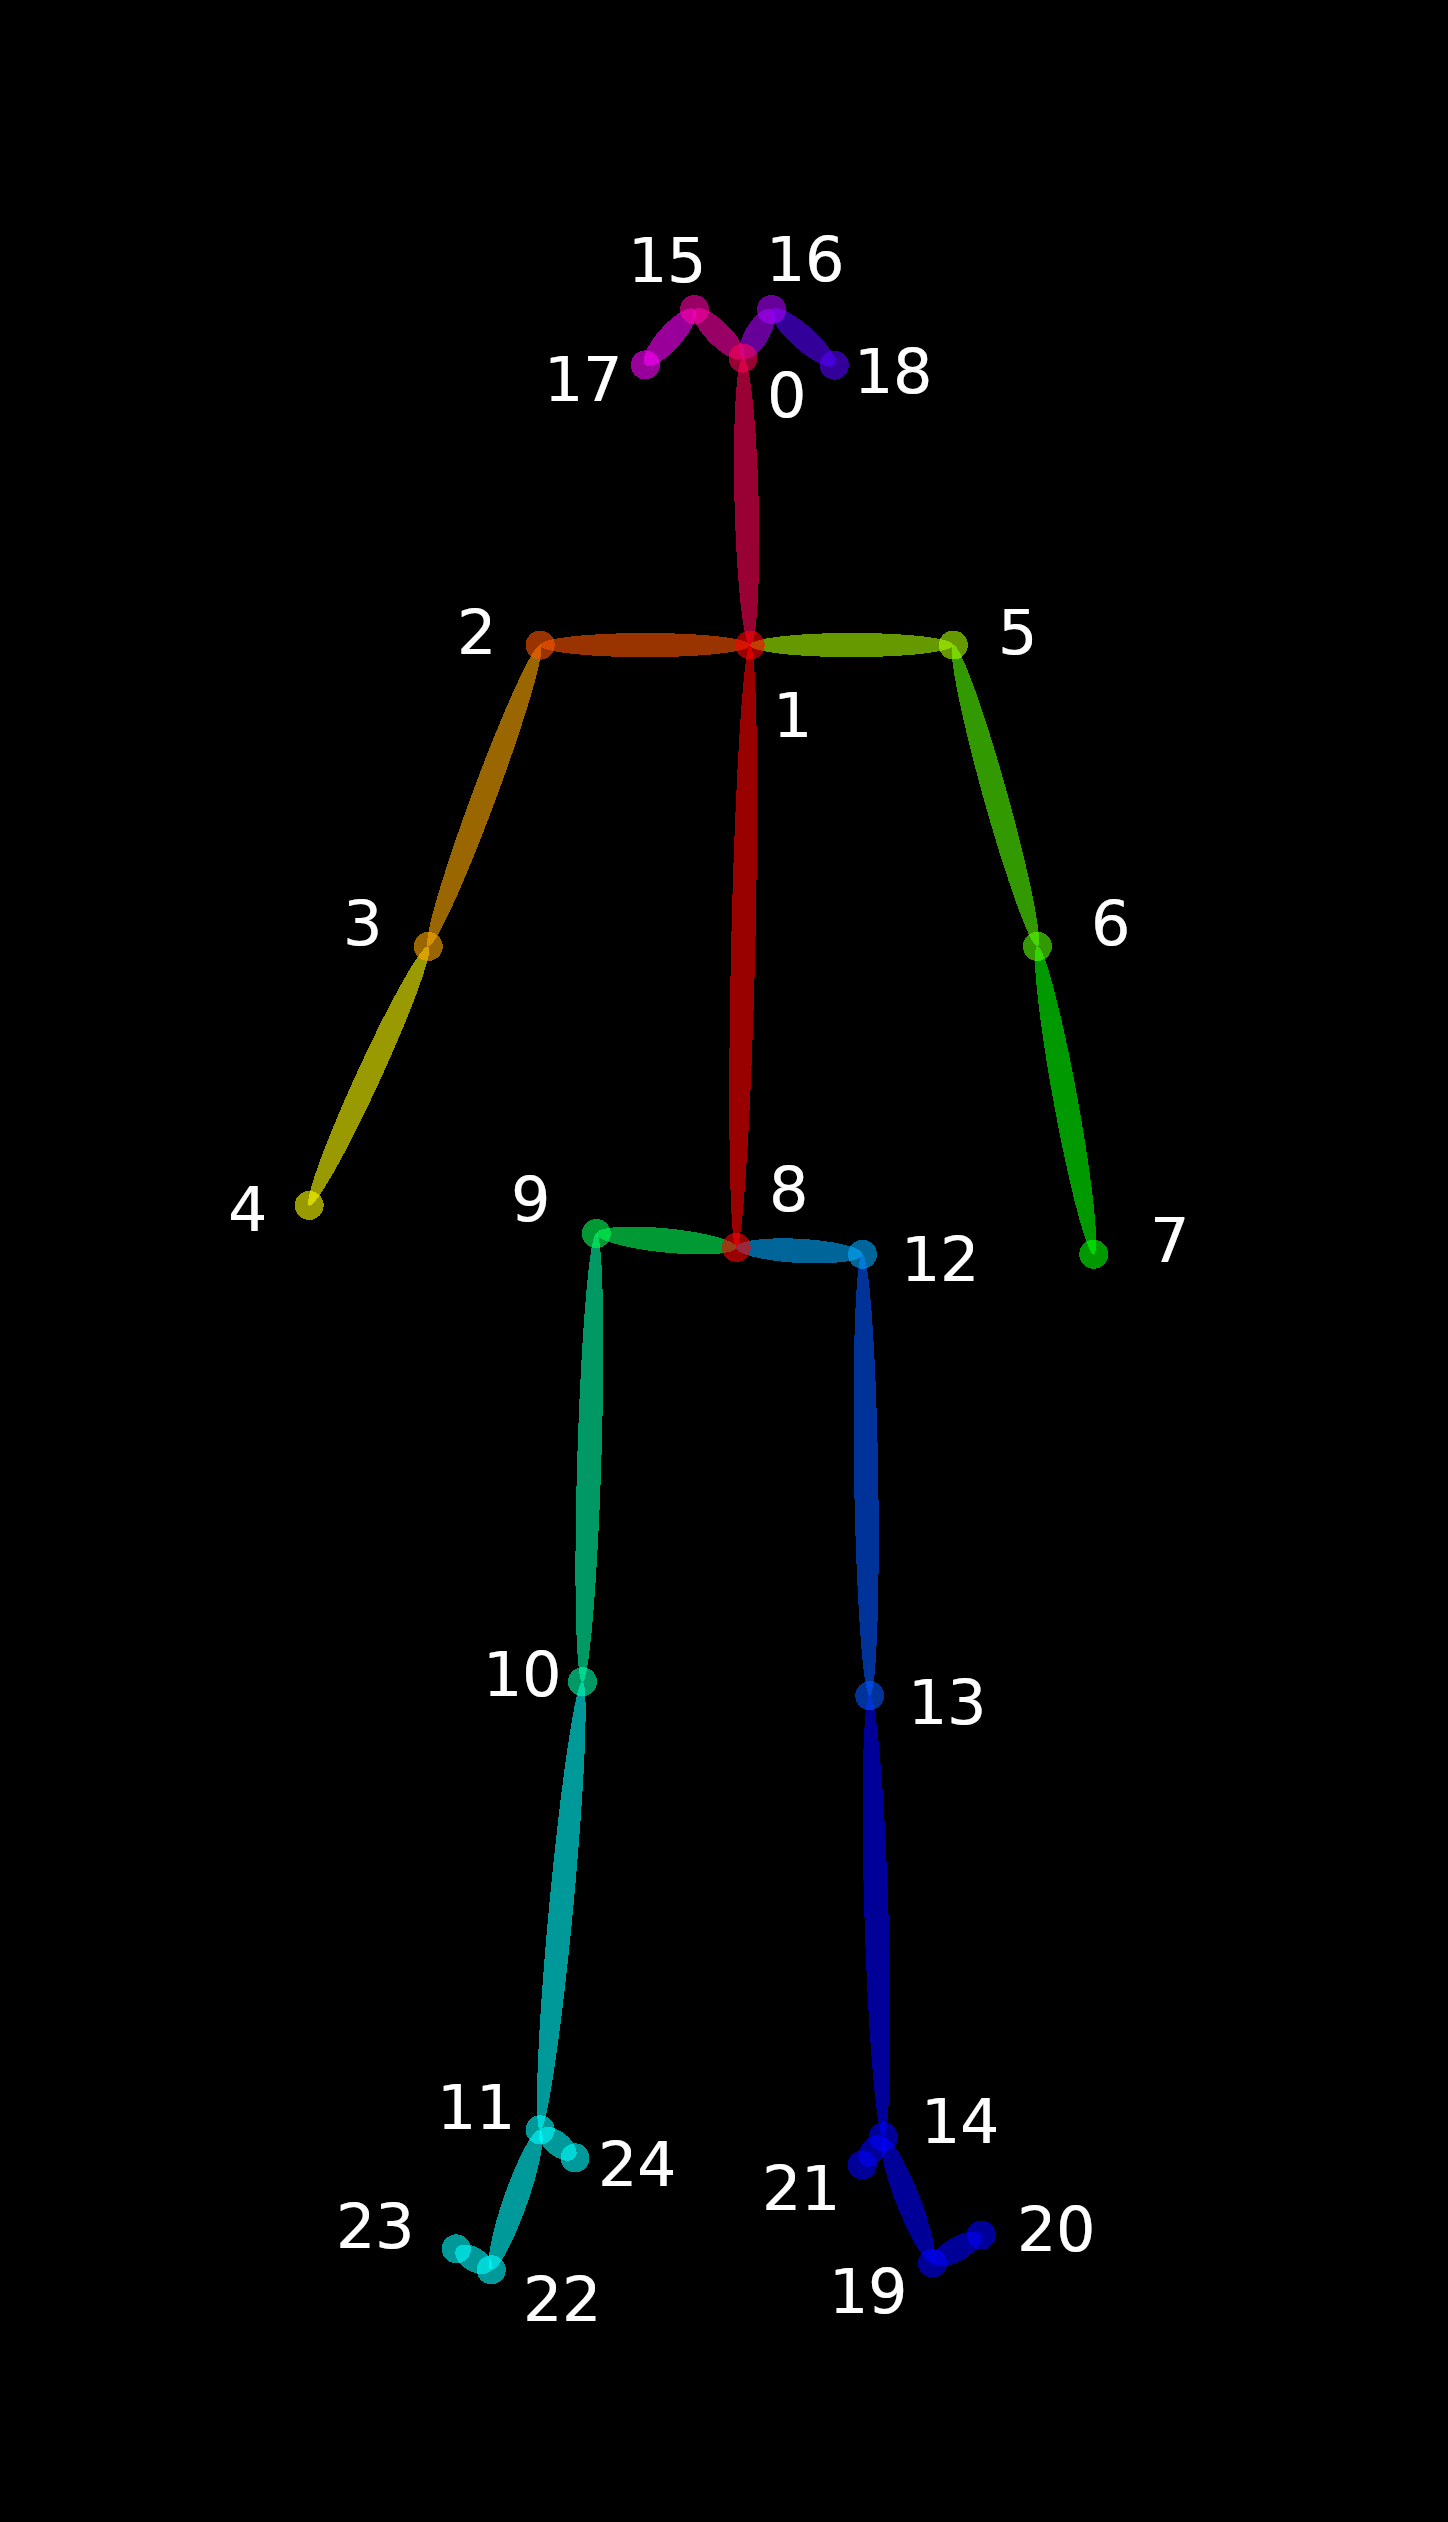


In [ ]:
!ls

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
#나중에 tippint point frame 찾는 코드
def find_frame(cnt, dir):
  token=0
  video=cv2.VideoCapture(dir) # output d.mp4
  if video is None:
    print("no video")
  while True:
    ret,frame=video.read()
    if token==cnt:
      cv2_imshow(frame)
      cv2.waitkey()
      cv2.destroyAllWindows()

    if not ret:
      break
    token+=1



json 파일 구조는 다음과 같다.
pose_keypoints_2d: 몸체 위치가 x1, y1, c1, x2, y2, c2,... 와 같이 배열로 저장됨. x, y는 픽셀위치이나 0 ~ 1, -1 ~ 0 과 같이 정규화될 수 있음(keypoint_scale 옵션에 따라). c는 신뢰도로 0 ~ 1 사이값.
참고로, 각 키포인트 배열 위치 의미는 다음과 같다. 이 형식을 BODY_25 구조라 한다(참고 - OpenPose Demo Output).
//     {0,  "Nose"},//     {1,  "Neck"},//     {2,  "RShoulder"},//     {3,  "RElbow"},//     {4,  "RWrist"},//     {5,  "LShoulder"},//     {6,  "LElbow"},//     {7,  "LWrist"},//     {8,  "MidHip"},//     {9,  "RHip"},//     {10, "RKnee"},//     {11, "RAnkle"},//     {12, "LHip"},//     {13, "LKnee"},//     {14, "LAnkle"},//     {15, "REye"},//     {16, "LEye"},//     {17, "REar"},//     {18, "LEar"},//     {19, "LBigToe"},//     {20, "LSmallToe"},//     {21, "LHeel"},//     {22, "RBigToe"},//     {23, "RSmallToe"},//     {24, "RHeel"},//     {25, "Background"}

![image.png](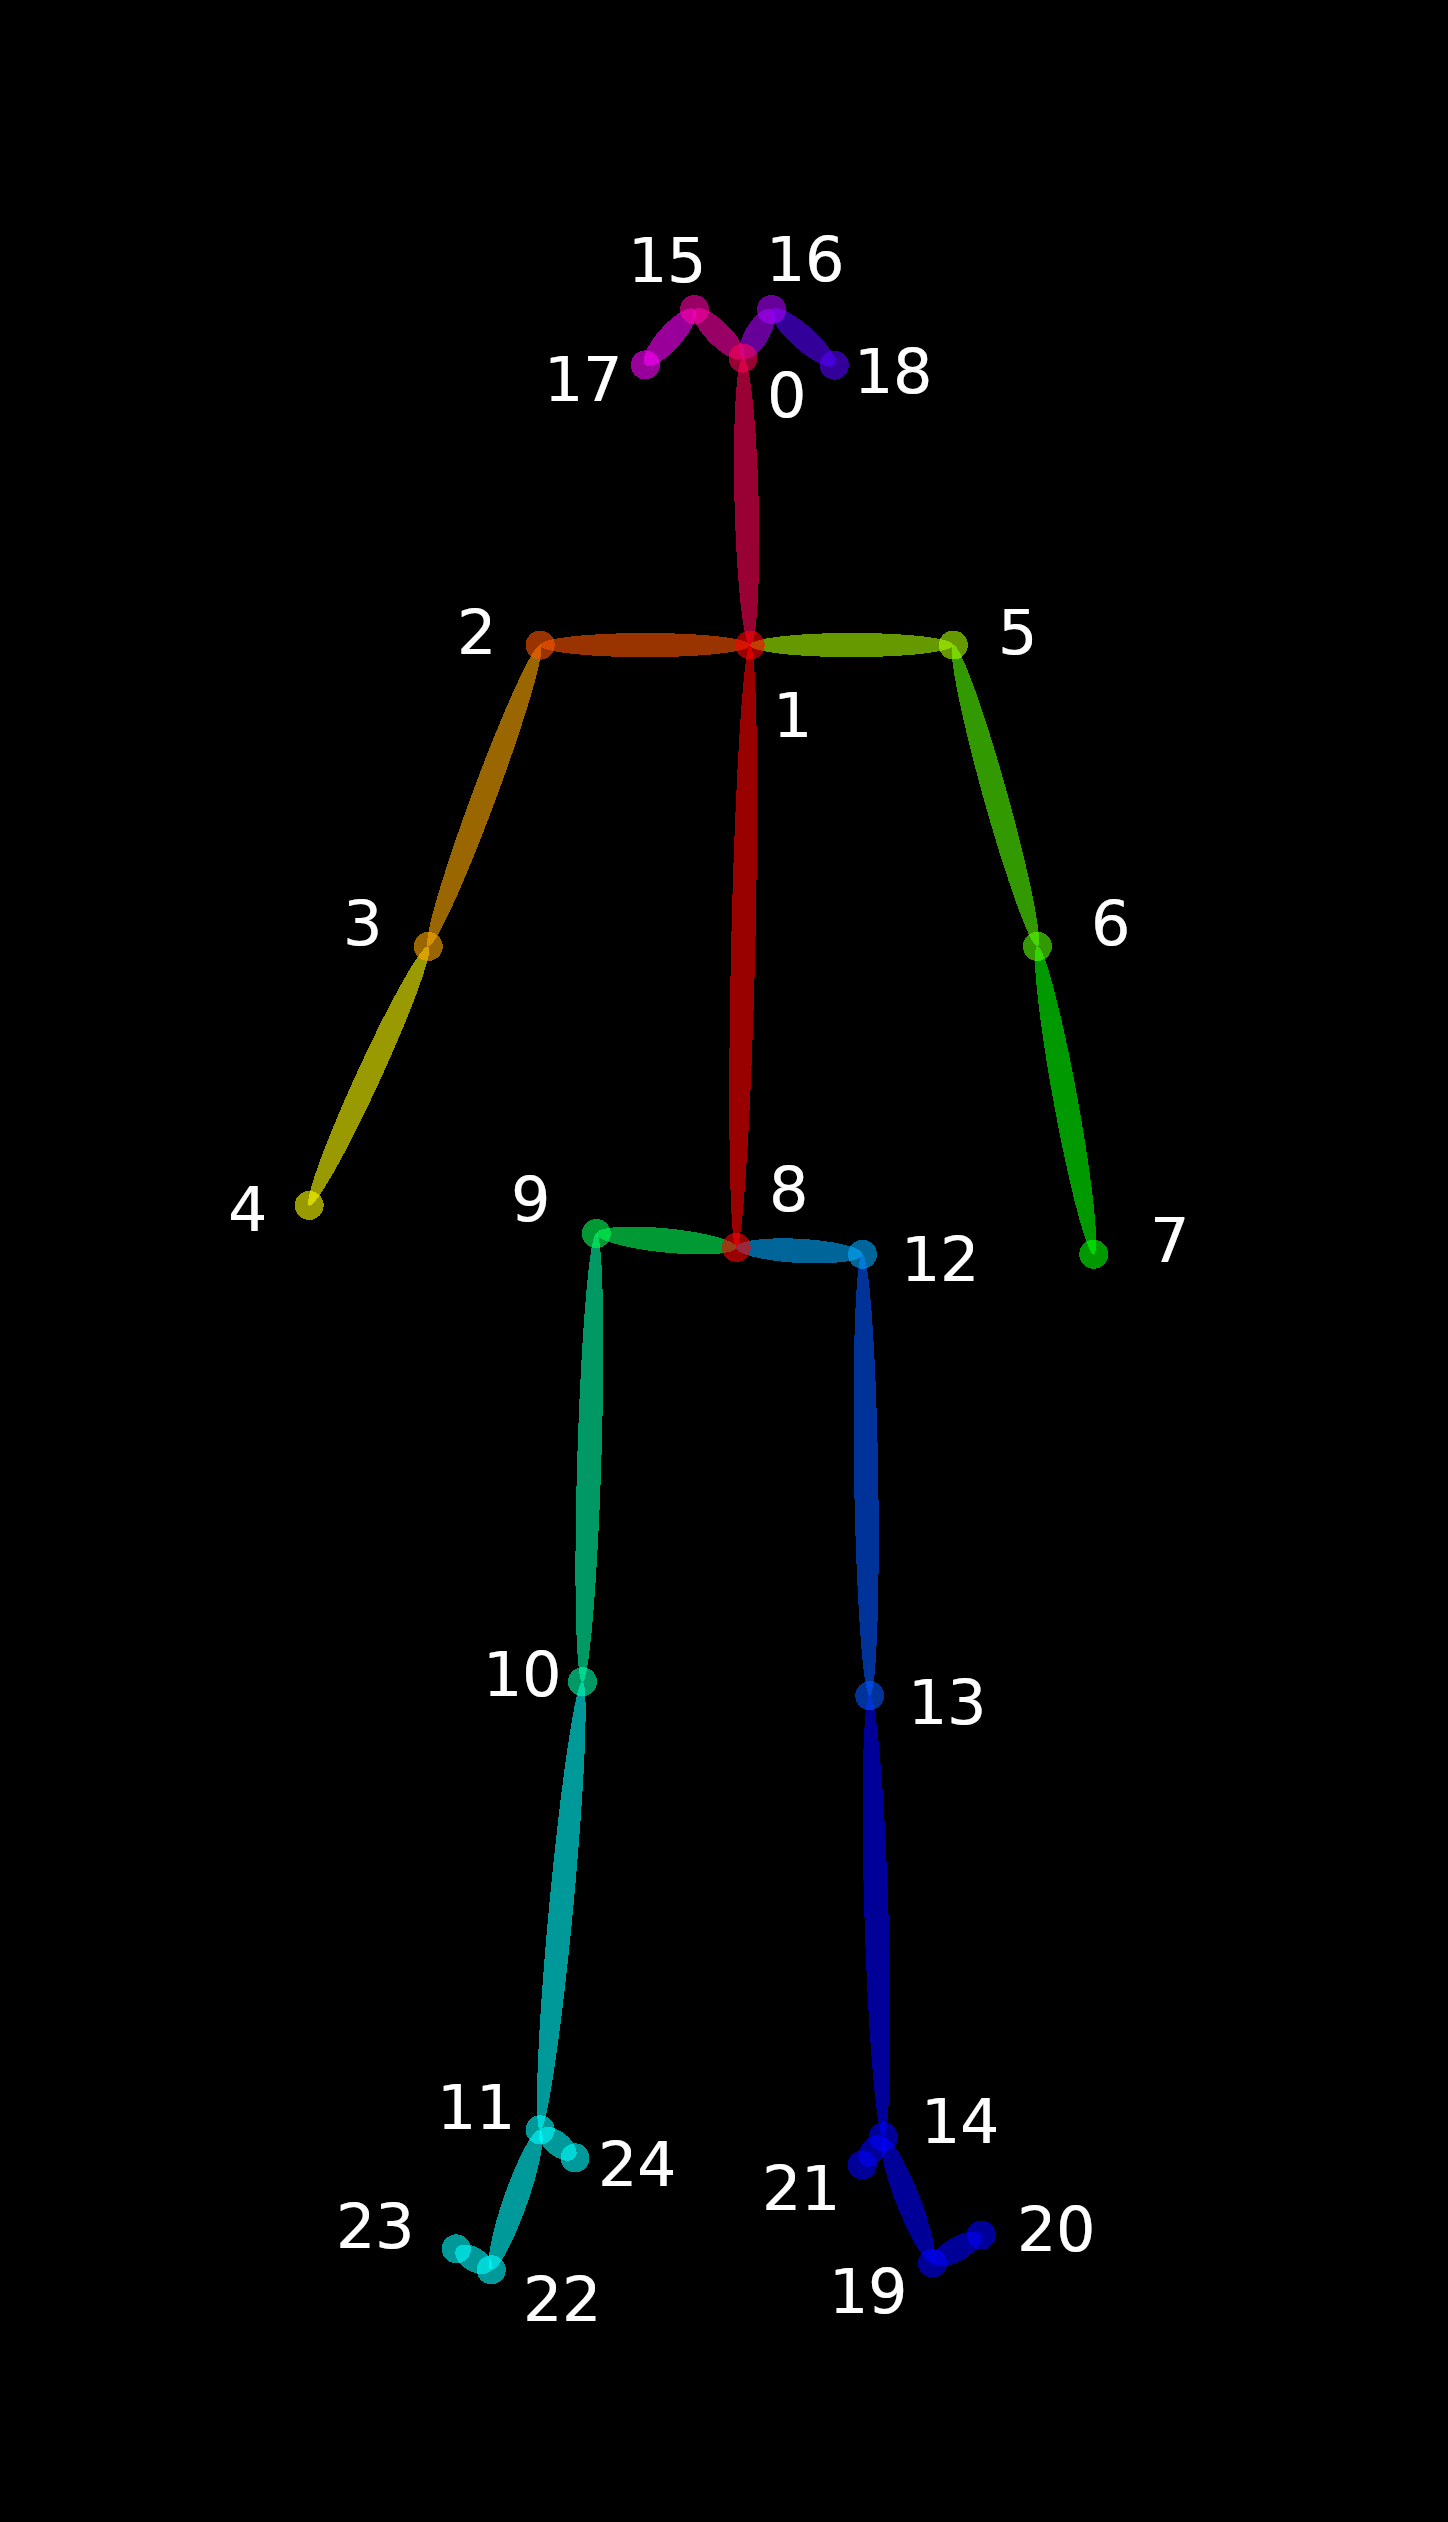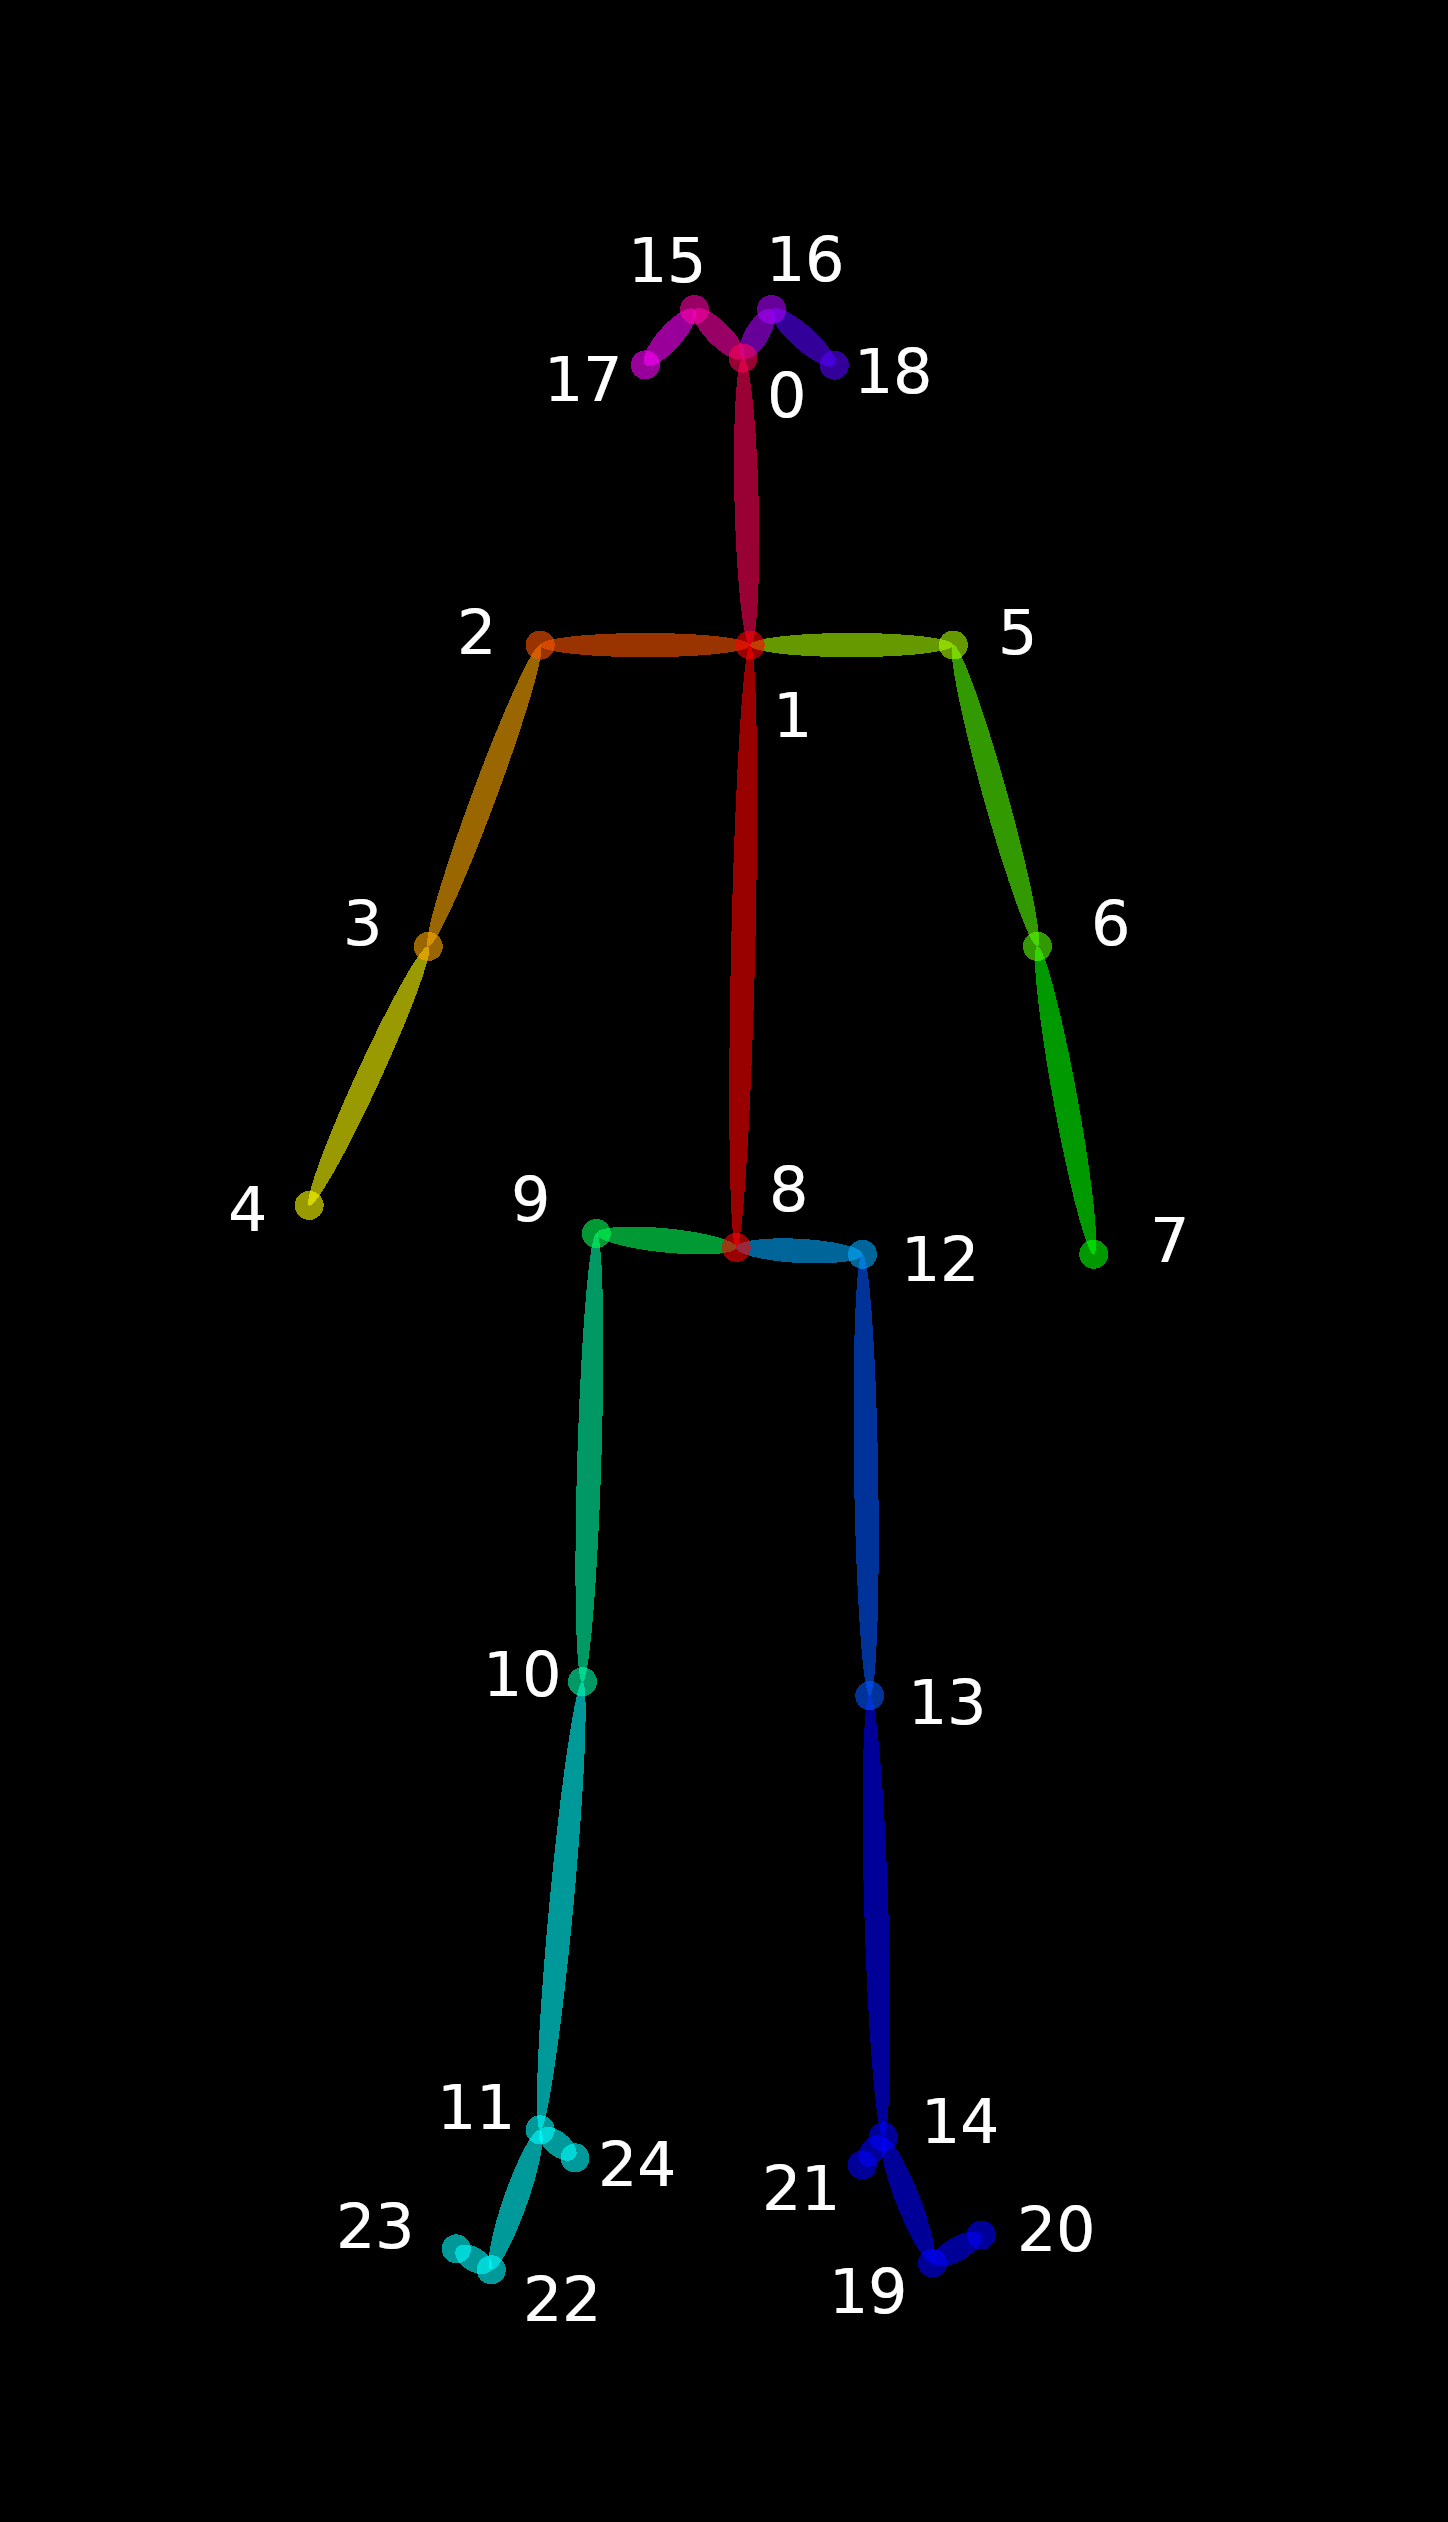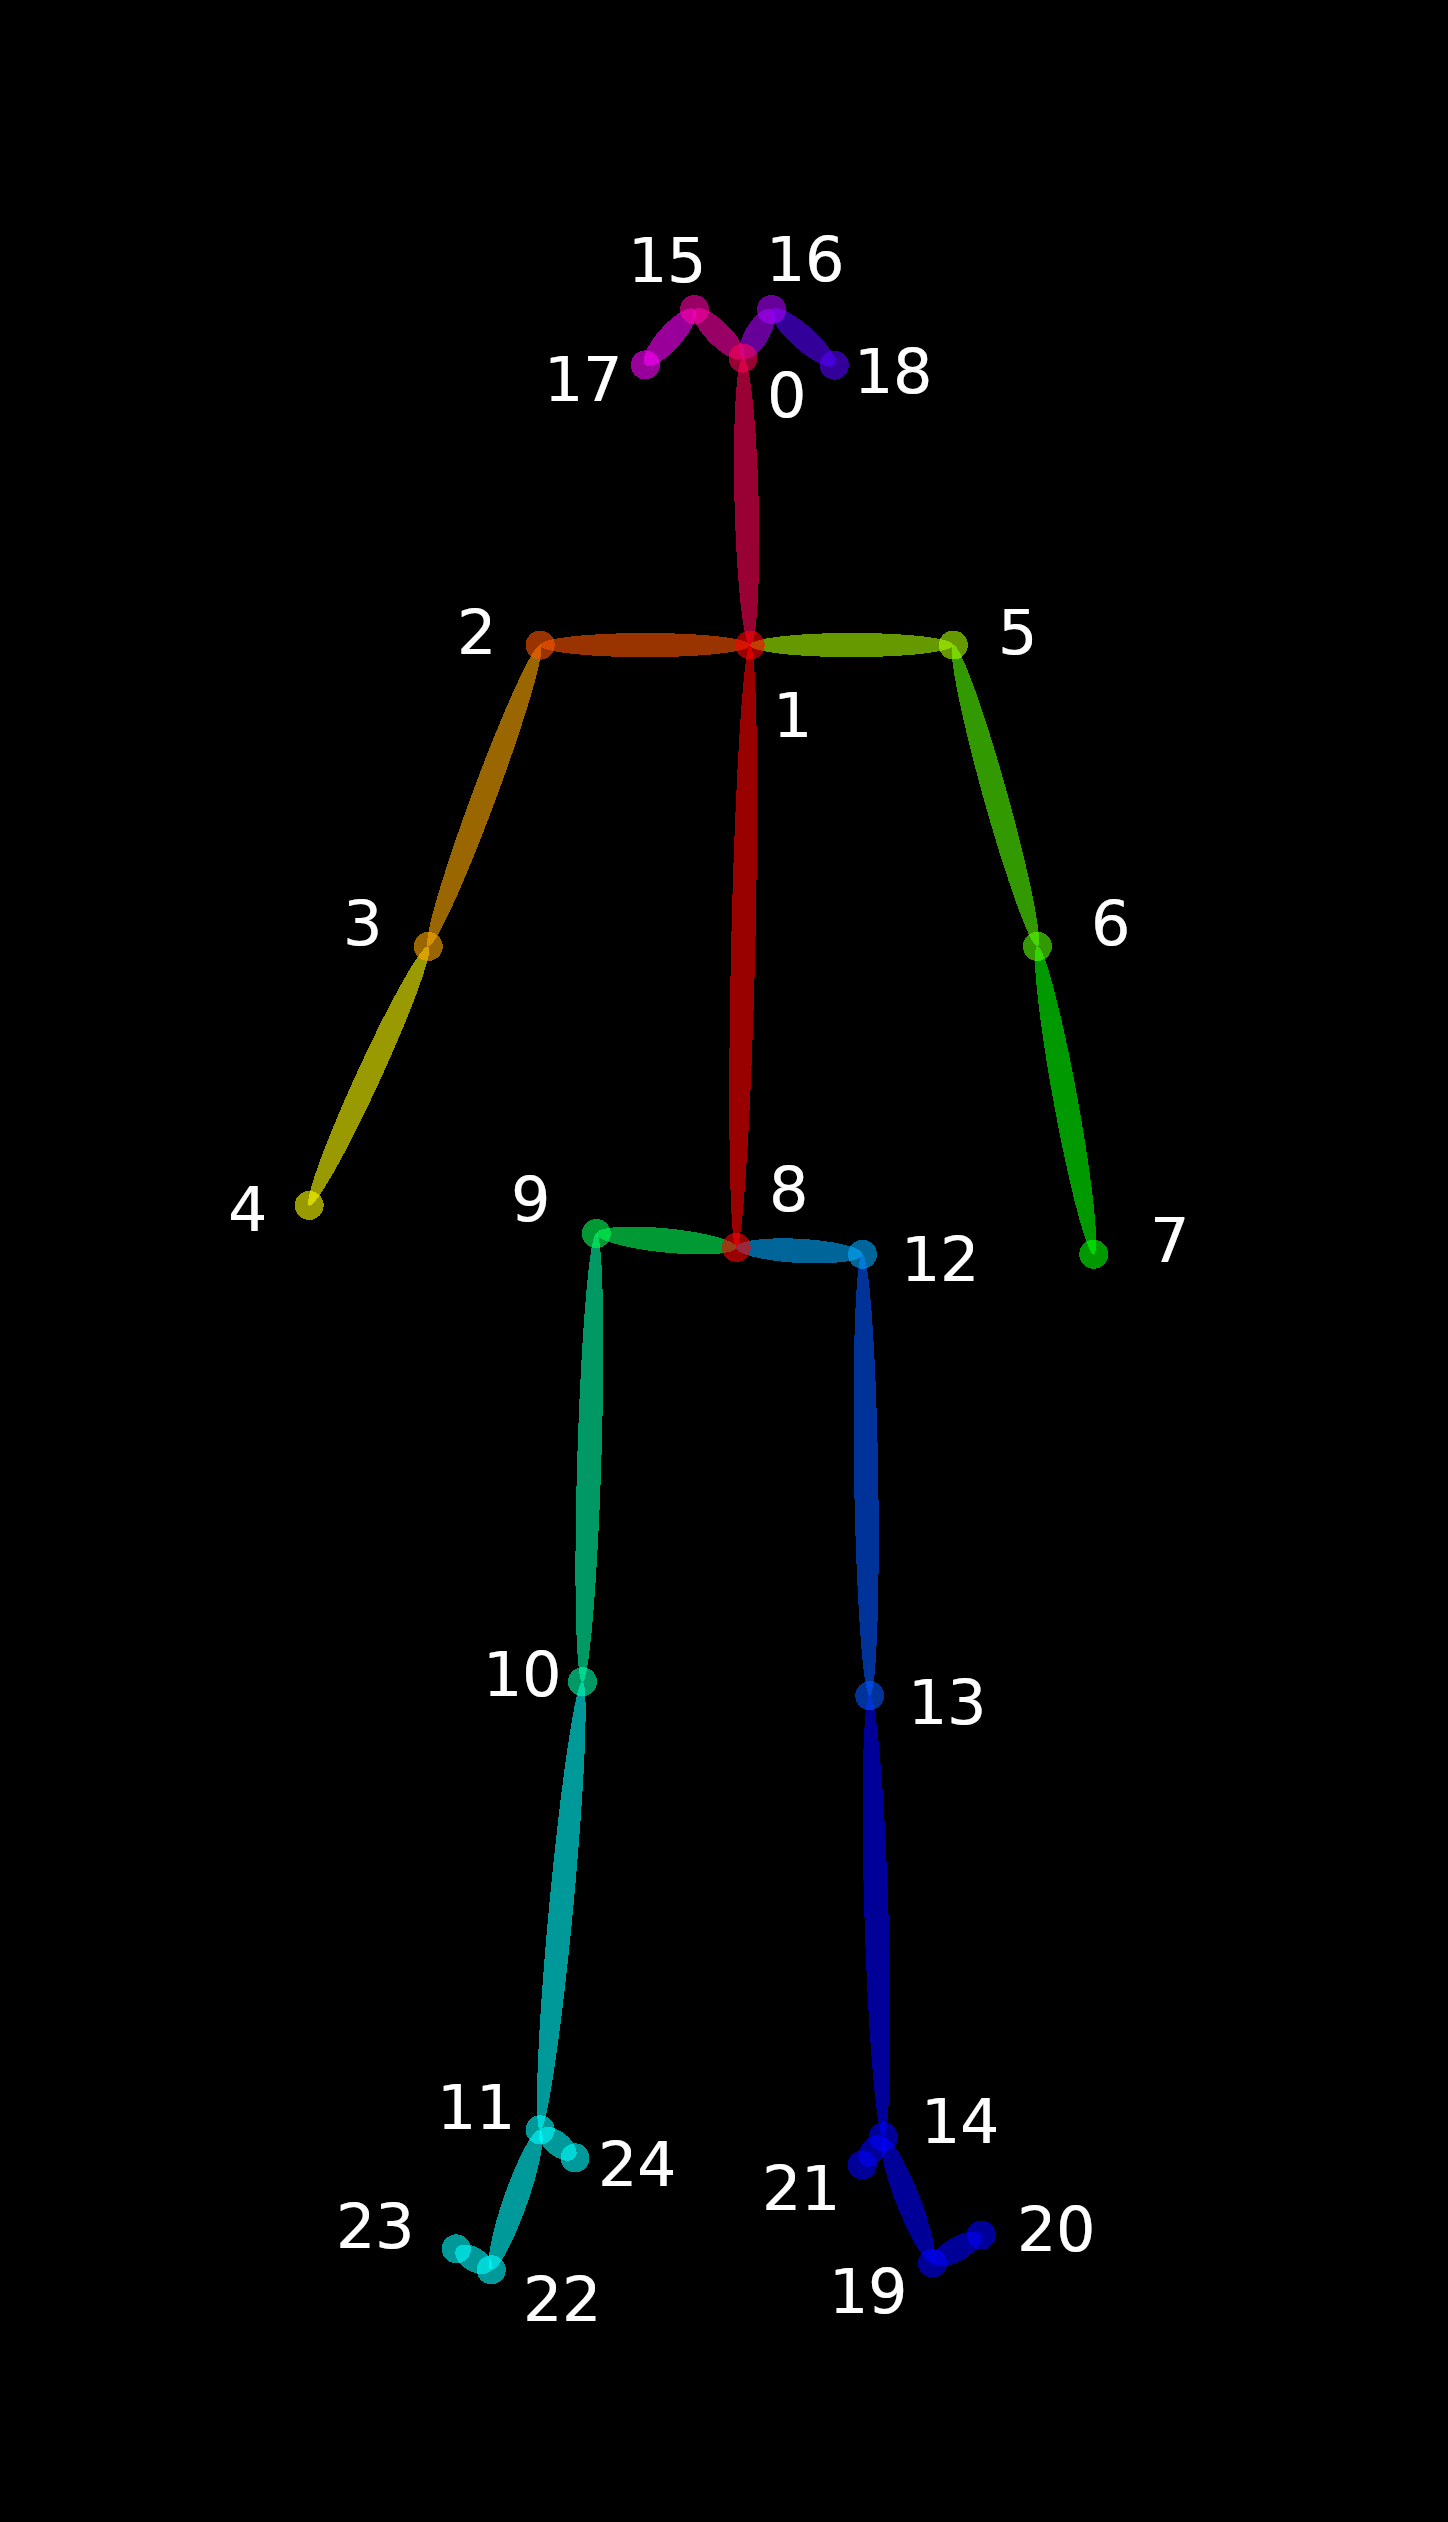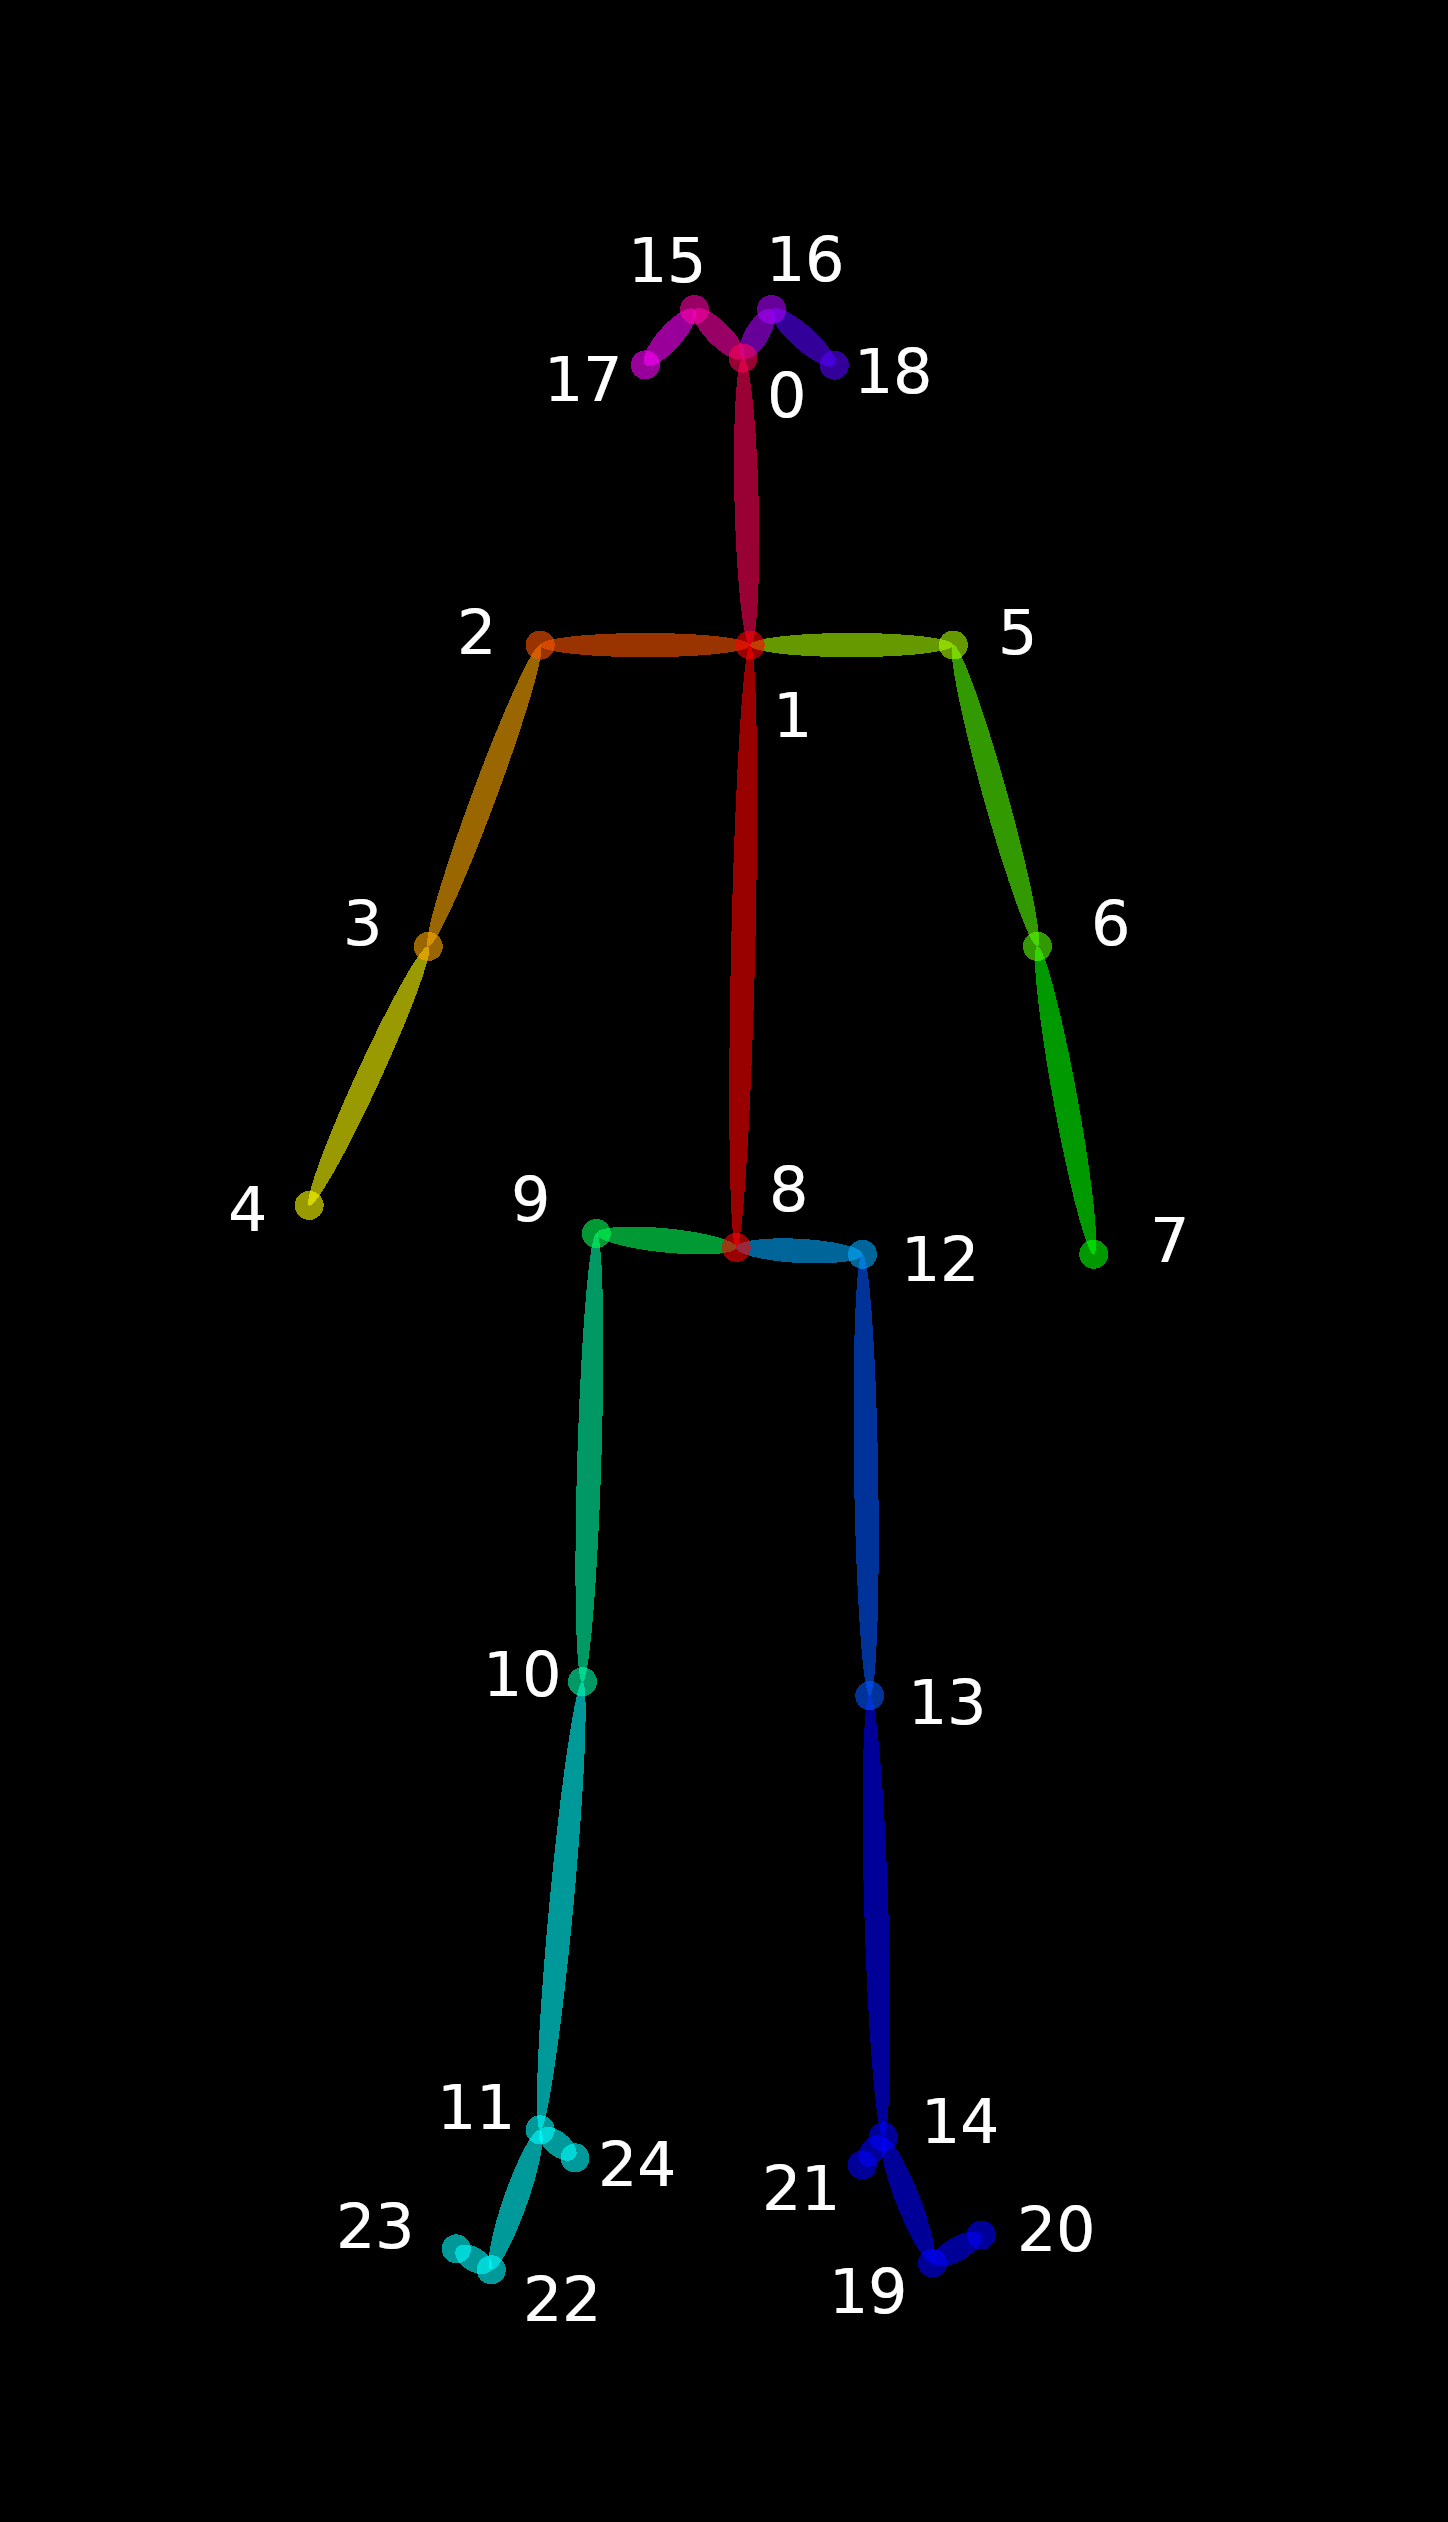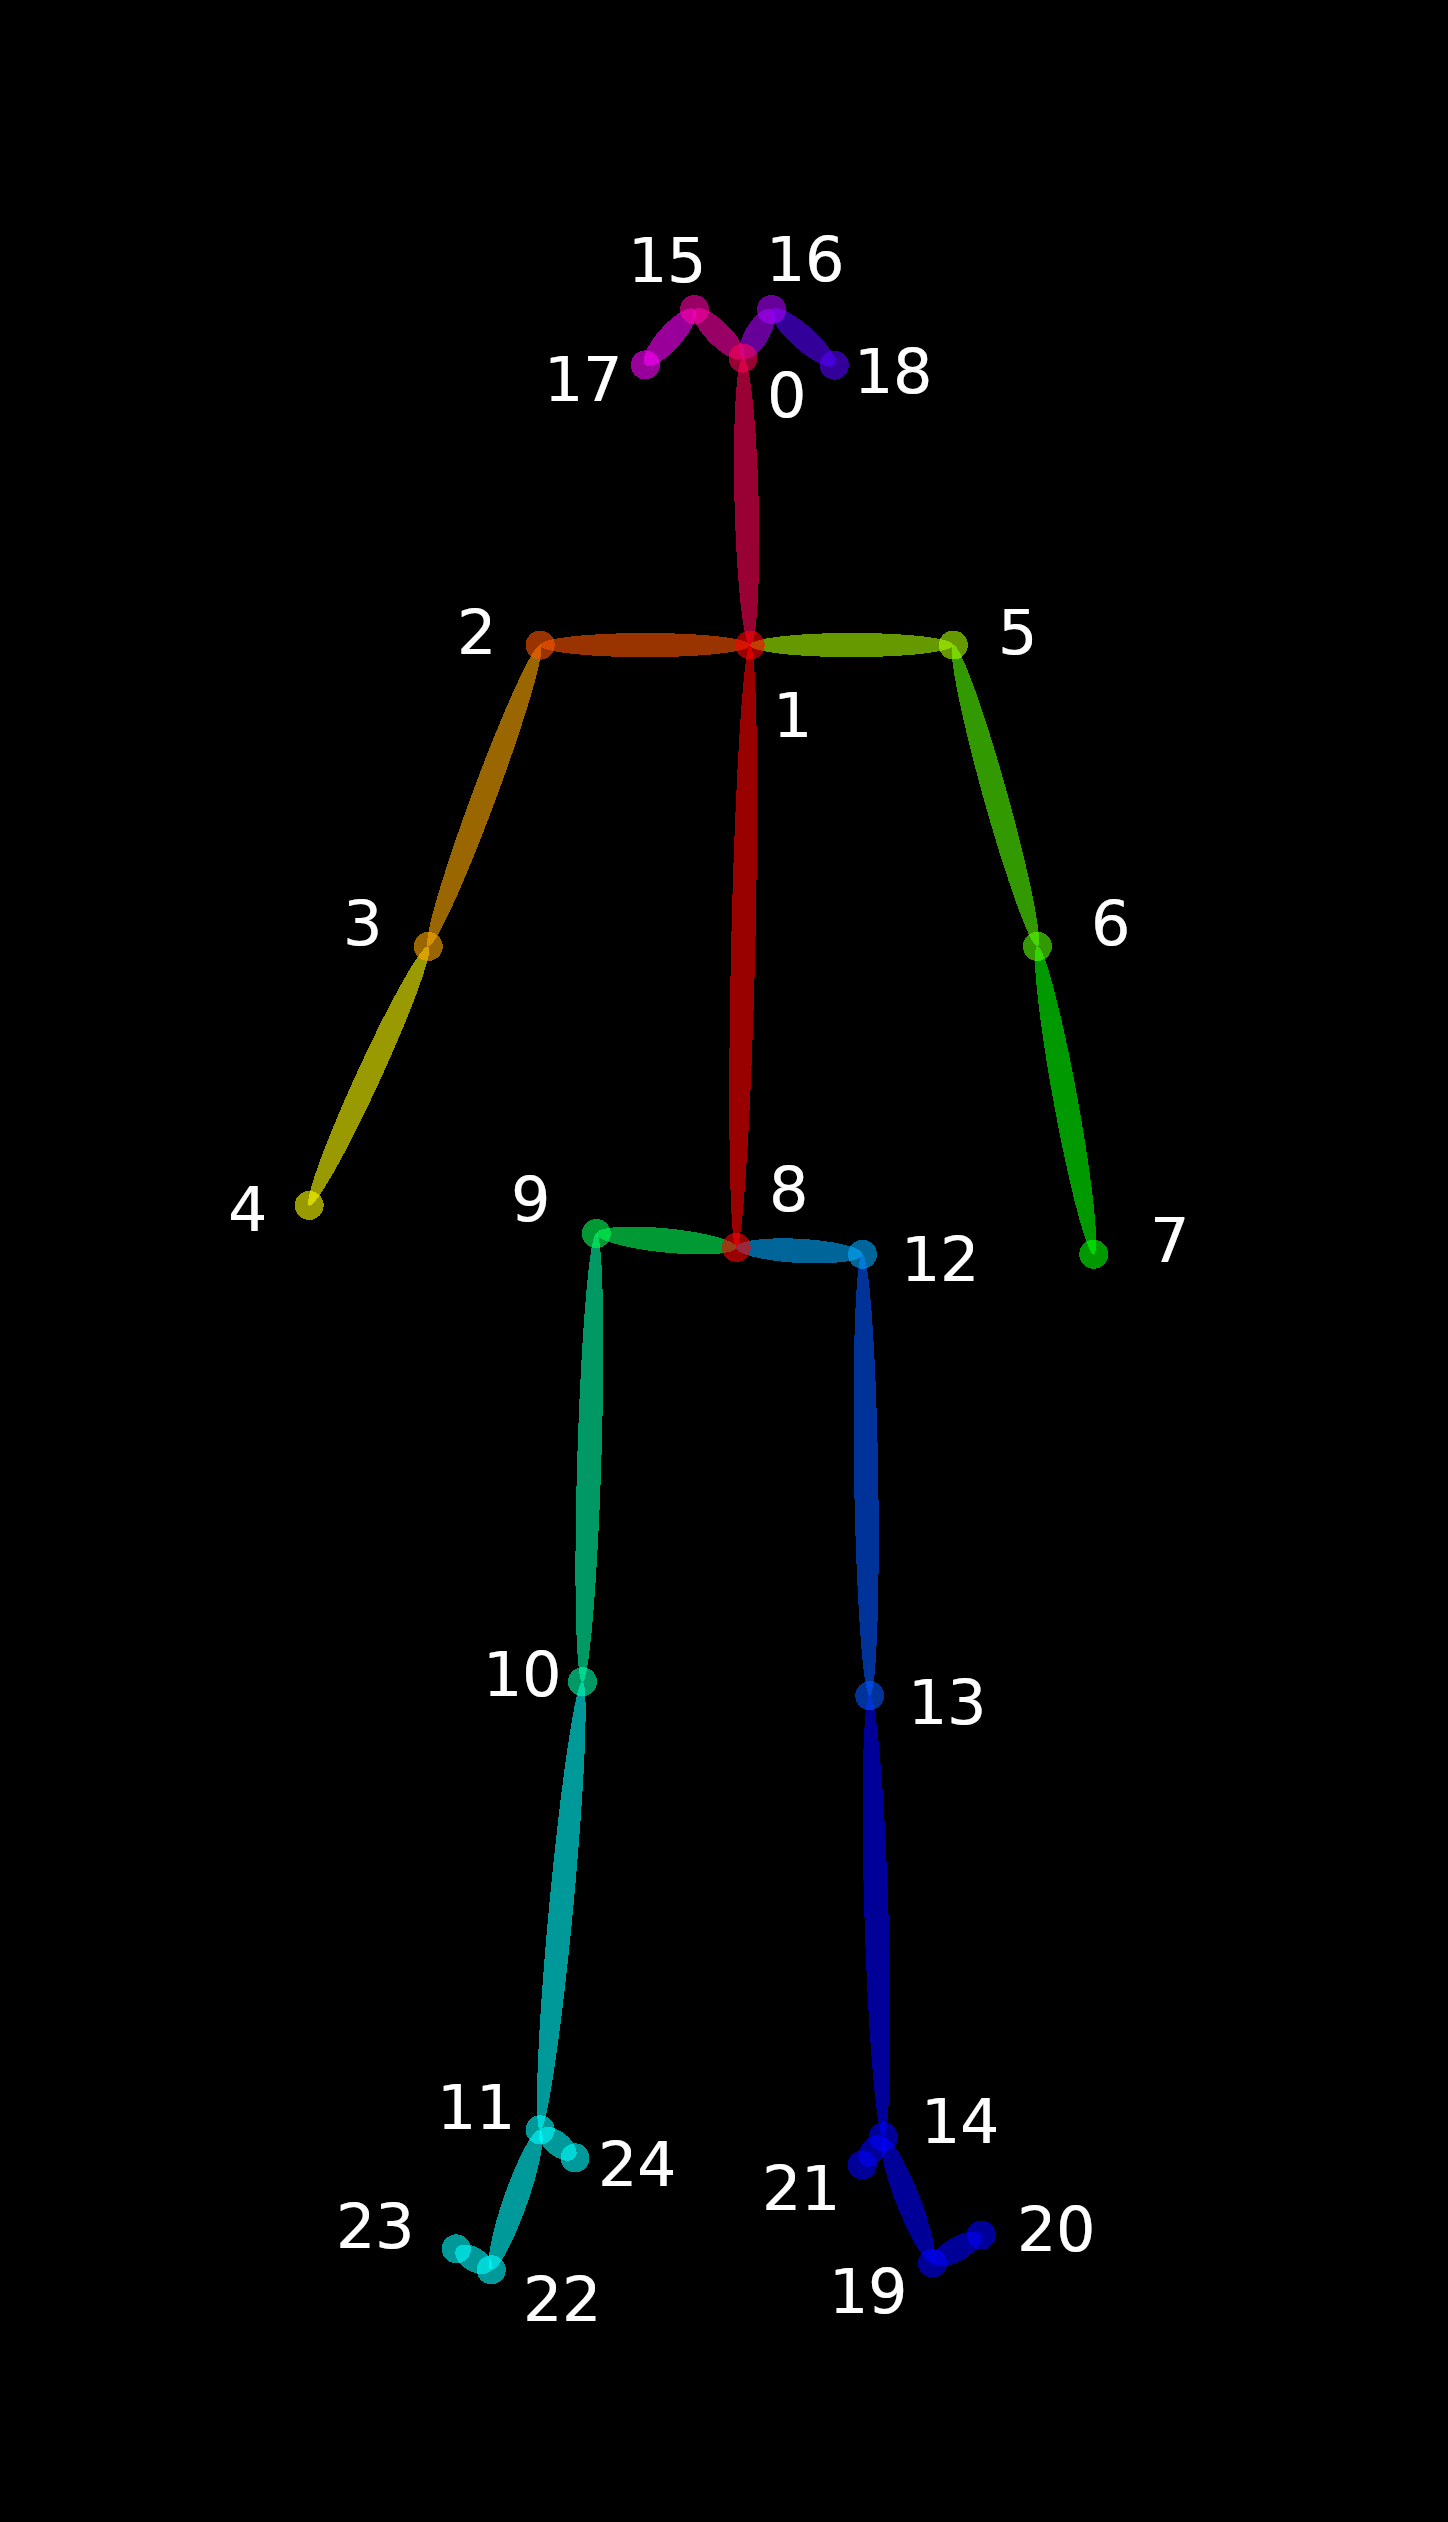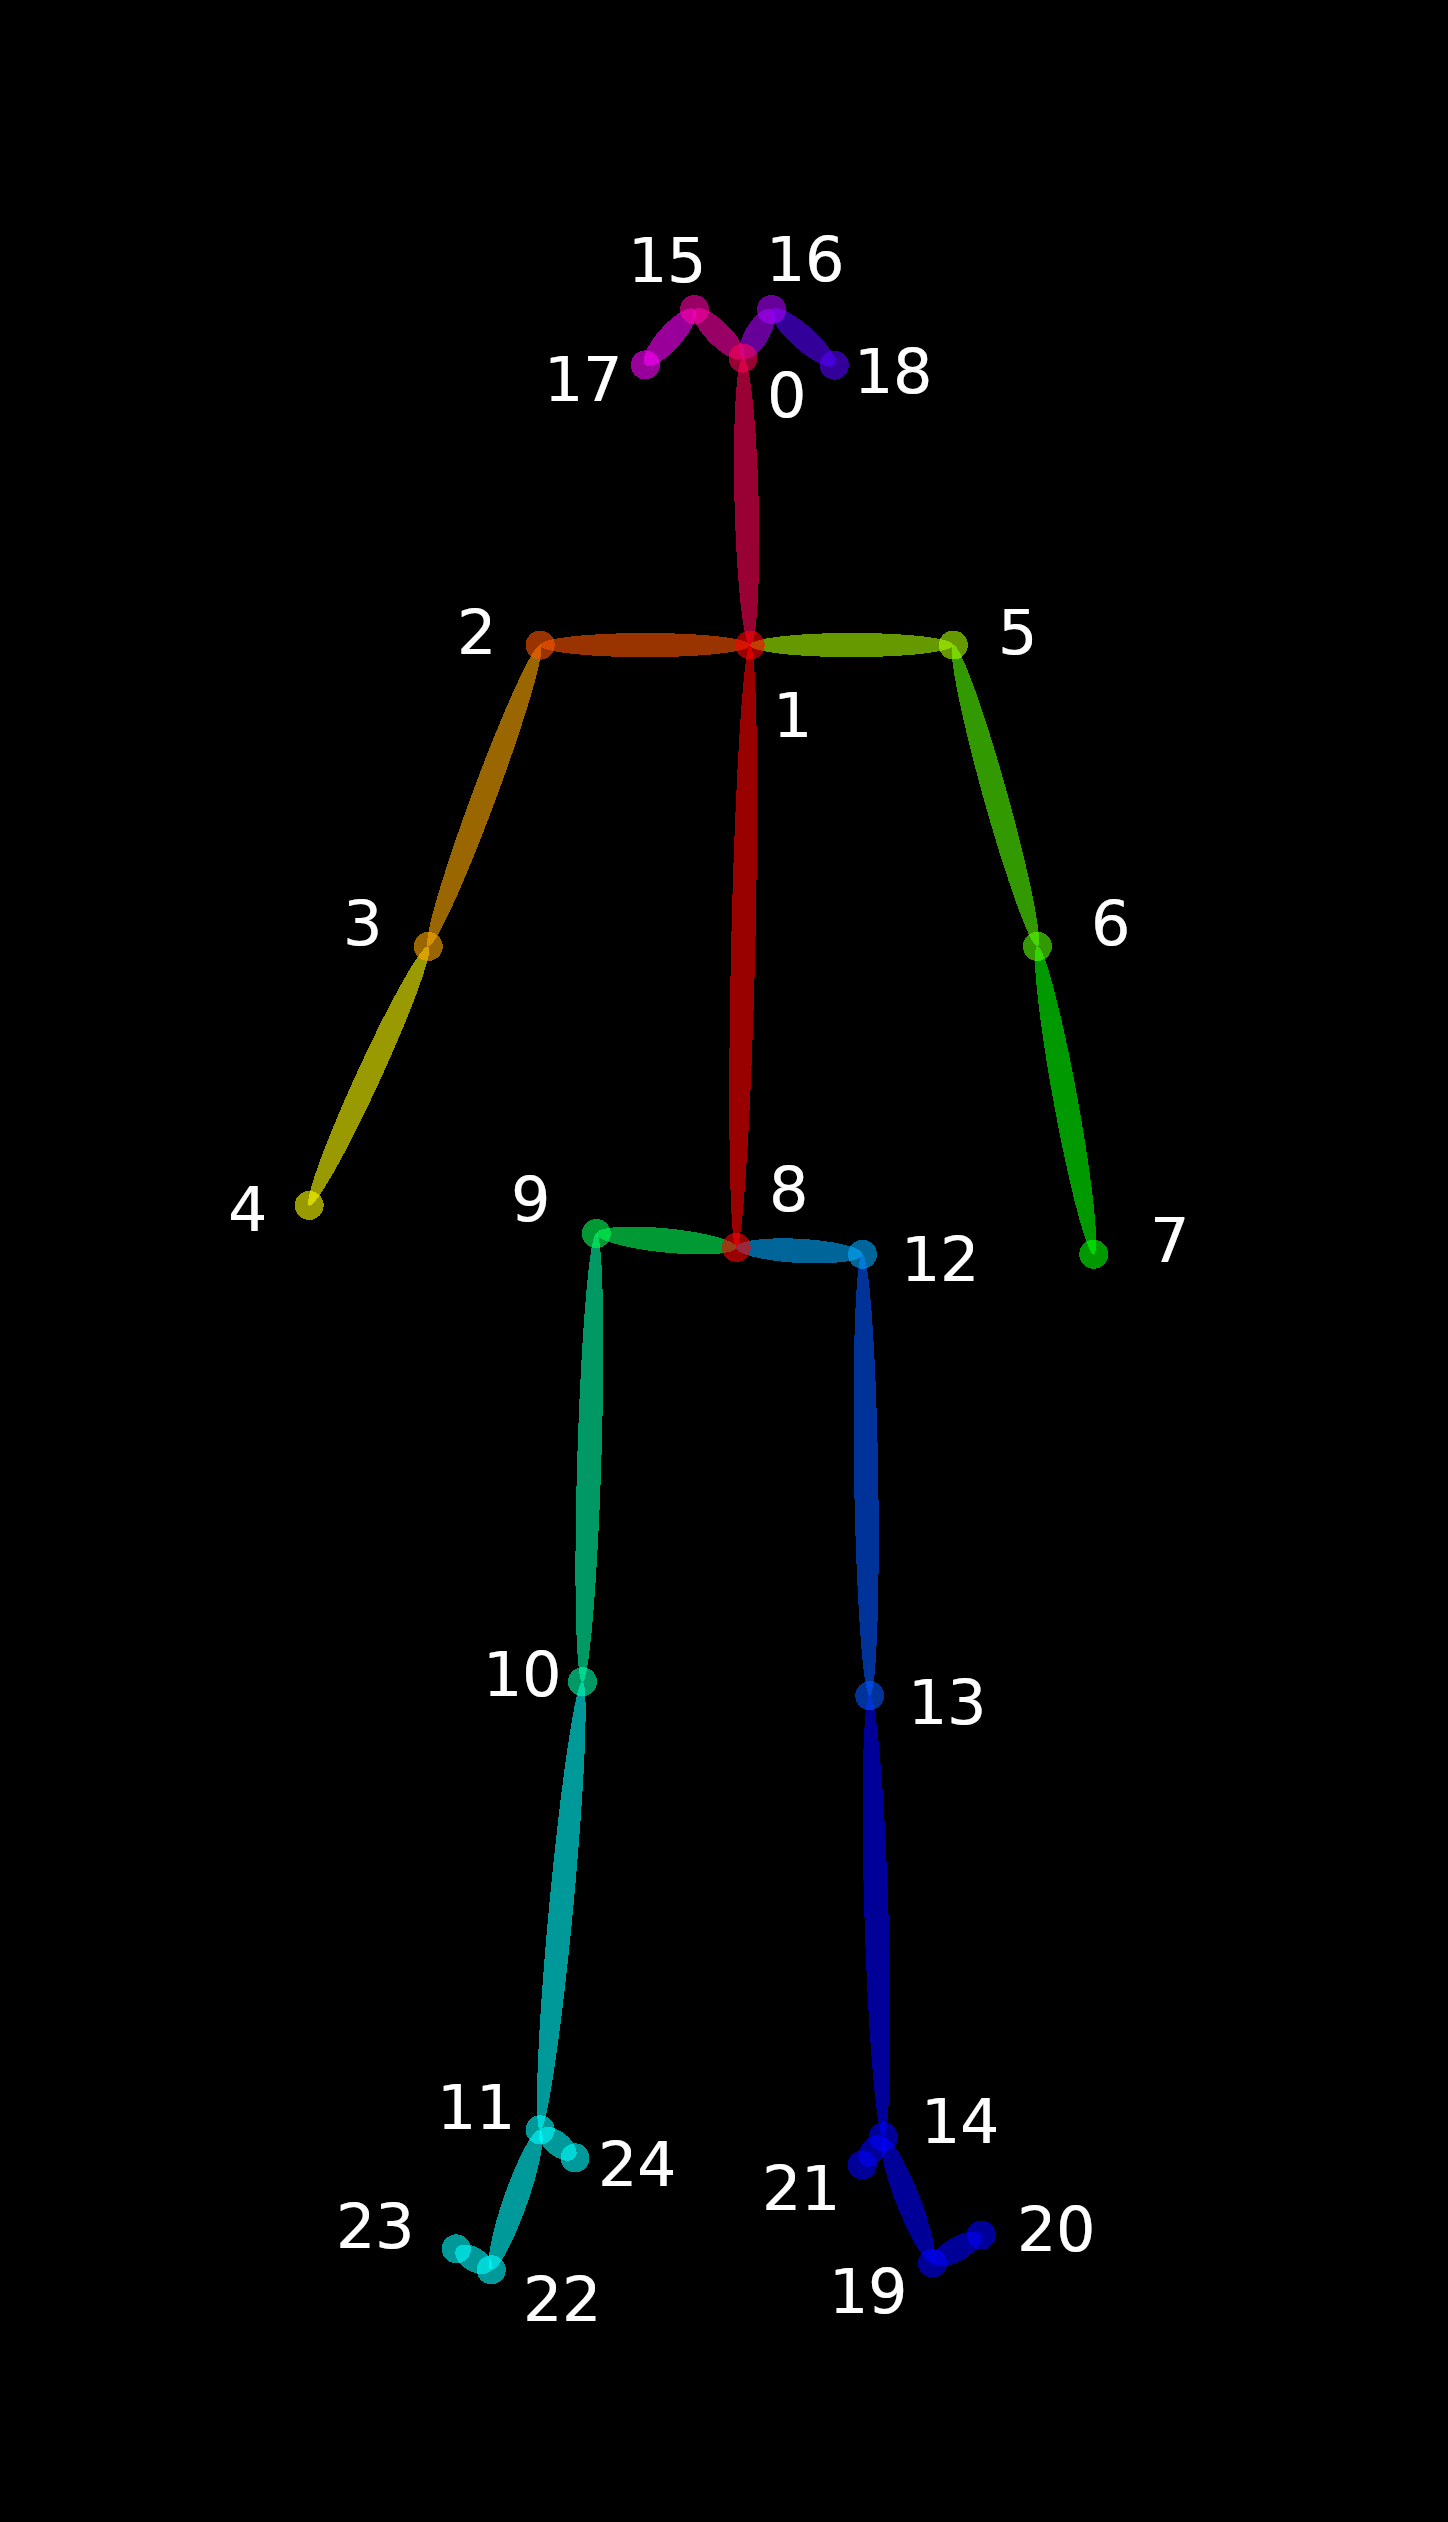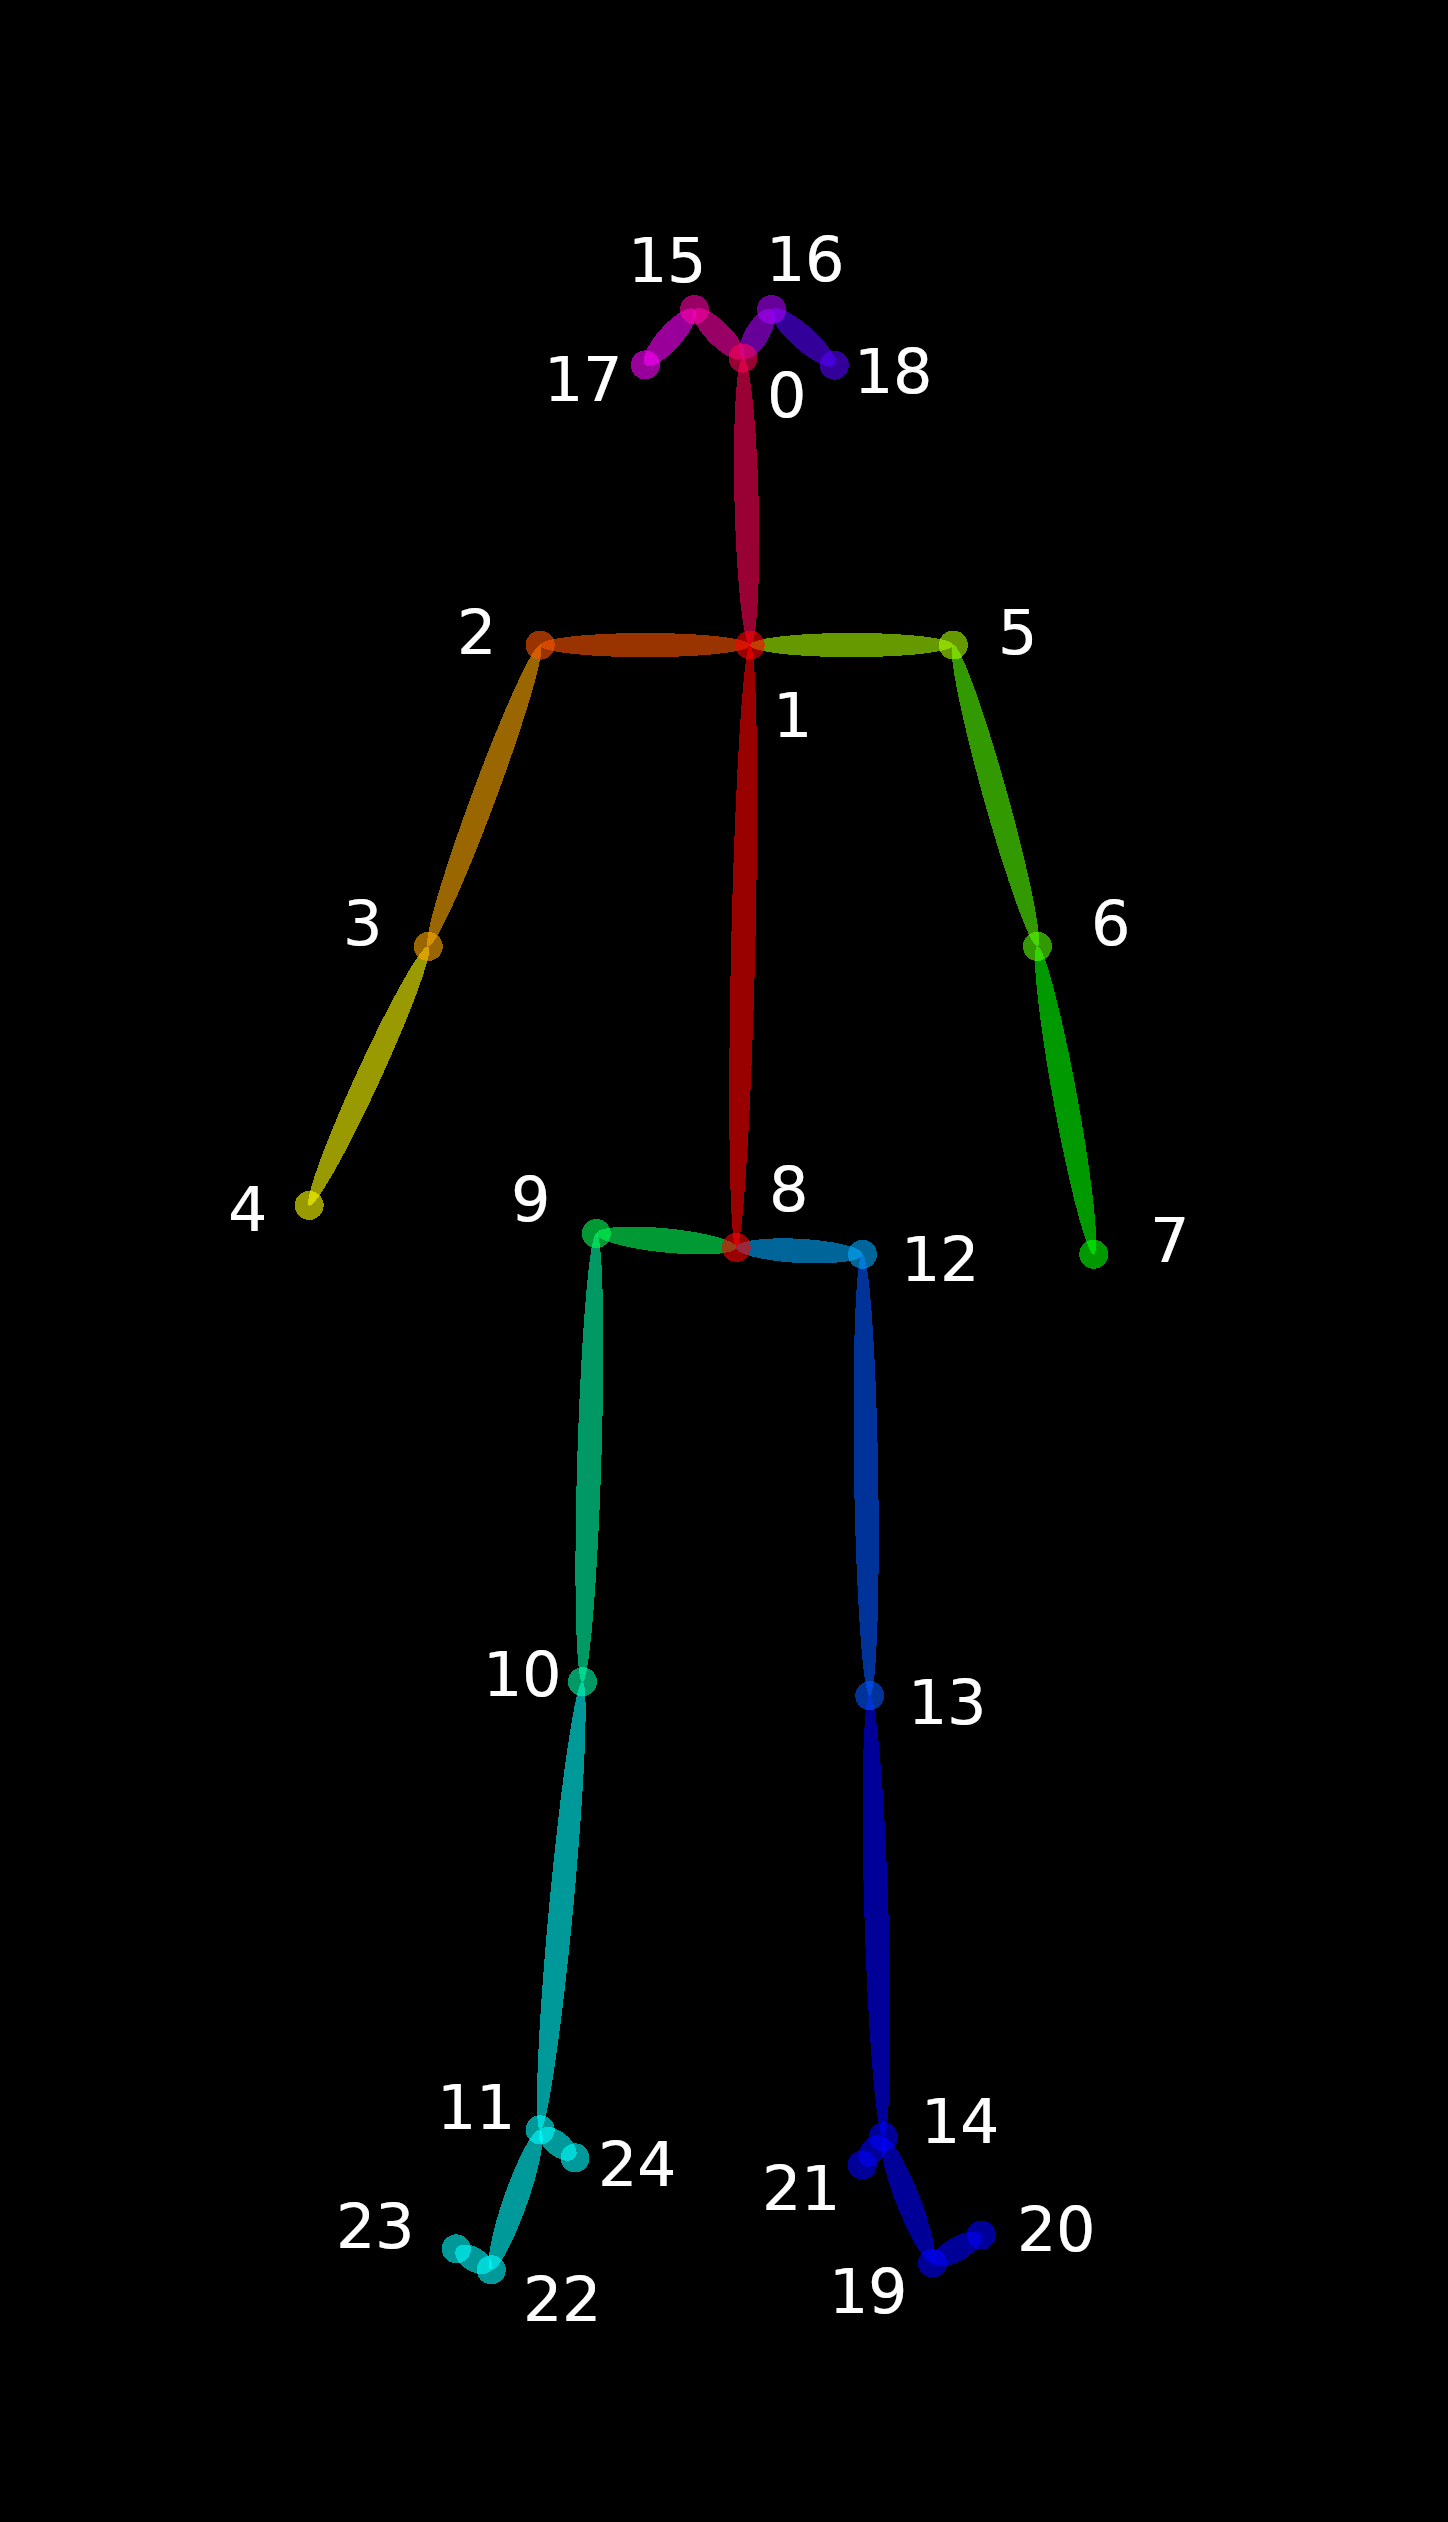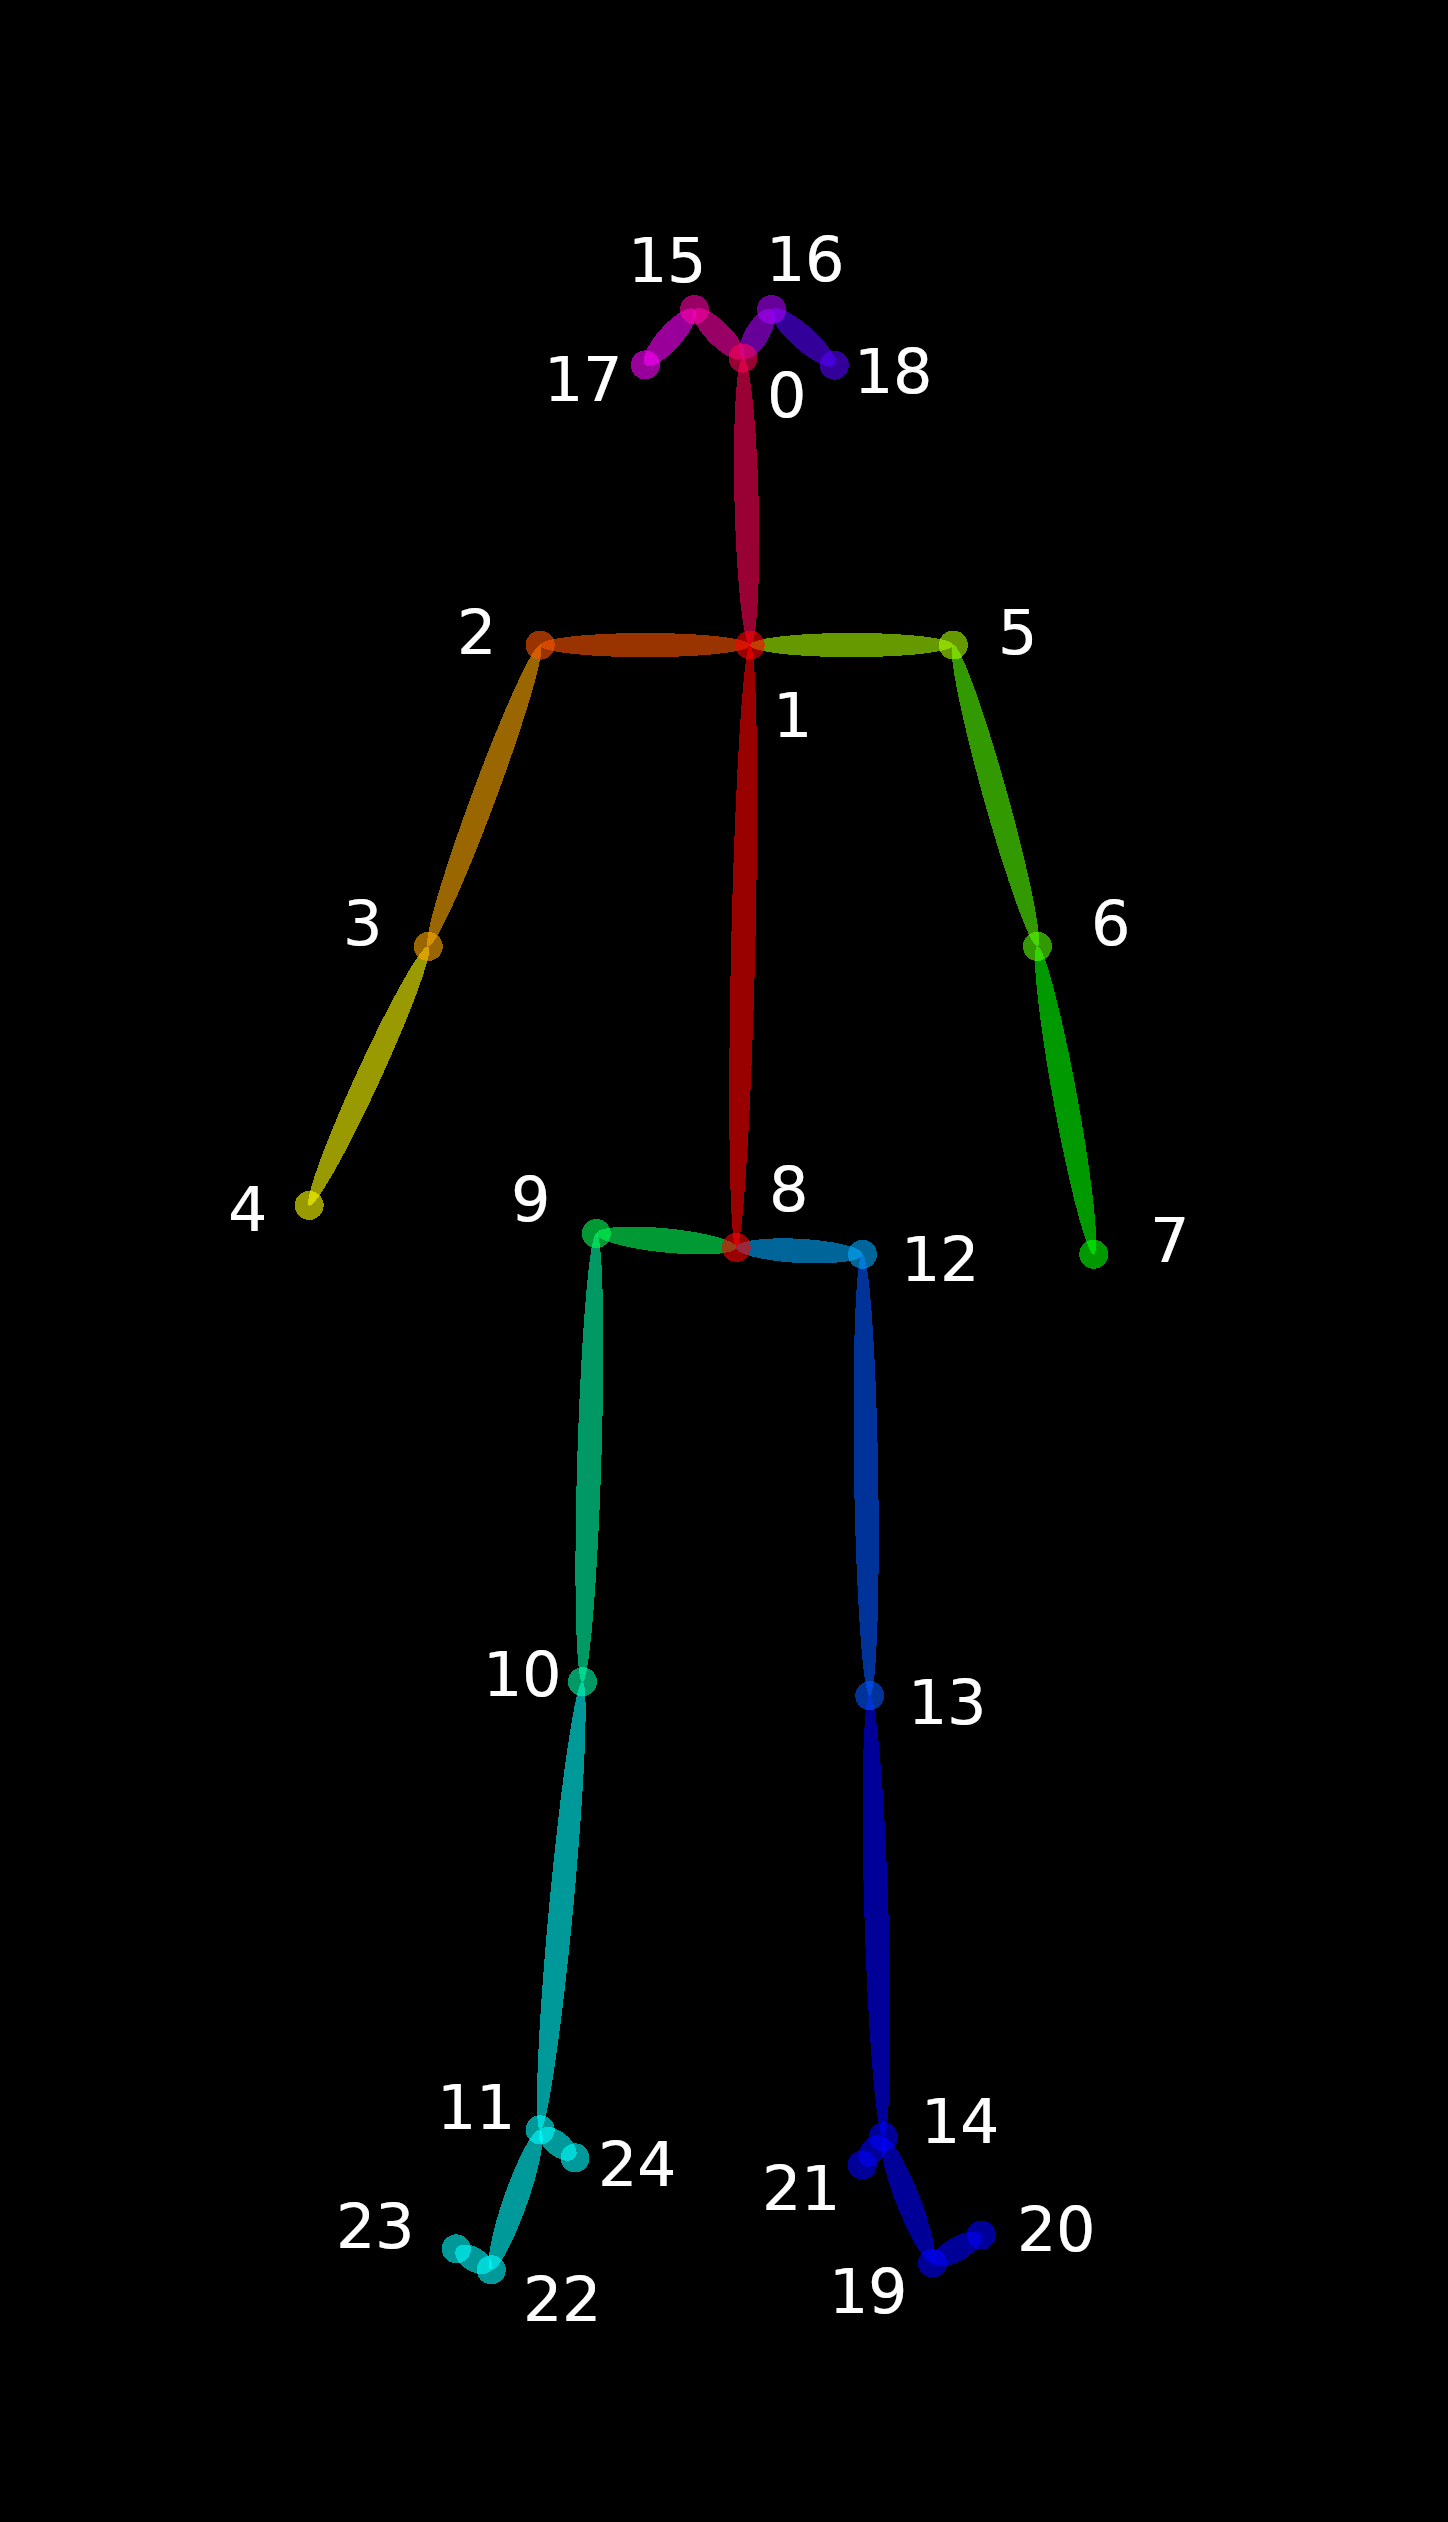)

BODY_25 의미
